## Imports

In [1]:
import time
import pickle

import scipy
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio

import torch
import torch.nn as nn

import deepinv

from pnp_unrolling.unrolled_cdl import UnrolledCDL
from utils.measurement_tools import get_operators
from utils.tools import op_norm2
from pnp_unrolling.datasets import (
    create_imagenet_dataloader,
)


def plot_img(img, ax, title=None):
    img = img.detach().cpu().numpy().transpose(1, 2, 0).clip(0, 1)
    ax.imshow(img)
    ax.set_axis_off()
    if title:
        ax.set_title(title)


DATASET = "bsd"
COLOR = True
DEVICE = "cuda:0" #"cuda:3"
STD_NOISE = 0.05

# Here the dataset is "BSD" but we use the same create_imagenet_dataloader
# function which need to set dataset="imagenet"
create_dataloader = create_imagenet_dataloader
DATA_PATH = "./BSDS500/BSDS500/data/images"
DATASET = "imagenet"

/users/eleves-b/2021/jeremie.touati/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:datasets:PyTorch version 2.5.1 available.


## Creating and training all denoisers

In [2]:
def get_denoiser(model, **kwargs):

    if model == "drunet":
        nc = 3 if COLOR else 1
        net = deepinv.models.DRUNet(
            in_channels=nc,
            out_channels=nc,
            nc=[64, 128, 256, 512],
            nb=4,
            act_mode="R",
            downsample_mode="strideconv",
            upsample_mode="convtranspose",
            pretrained="download",
        )
        net = nn.DataParallel(net, device_ids=[int(DEVICE[-1])])
    elif model in ["analysis", "synthesis"]:
        unrolled_cdl = UnrolledCDL(type_unrolling=model, **kwargs)
        # Training unrolled networks
        net, *_ = unrolled_cdl.fit()
    else:
        raise ValueError(
            f"Requested denoiser {model} which is not available."
        )
    return net


params_model = {
    "kernel_size": 5,
    "lmbd": 1e-4,
    "color": COLOR,
    "device": DEVICE,
    "dtype": torch.float,
    "optimizer": "adam",
    "path_data": DATA_PATH,
    "max_sigma_noise": STD_NOISE,
    "min_sigma_noise": STD_NOISE,
    "mini_batch_size": 1,
    "max_batch": 10,
    "epochs": 50,
    "avg": False,
    "rescale": False,
    "fixed_noise": True,
    "D_shared": True,
    "step_size_scaling": 1.8,
    "lr": 1e-3,
    "dataset": DATASET,
}

components_list = [10, 50, 100]
layers_list = [1, 20]
n_rep_list = [20, 50, 100]

DENOISERS = {"DRUNet": dict(model="drunet")}
DENOISERS["DRUNet"]["net"] = get_denoiser(**DENOISERS["DRUNet"])

for denoiser_type in ["SD", "AD"]:
    for components in components_list:
        for layers in layers_list:
            params = {k: v for k, v in params_model.items()}
            params["n_layers"] = layers
            params["n_components"] = components
            
            # ----- #REPEAT = #LAYERS -----
            if denoiser_type == "SD":
                base_name = f"SD_{components}C_{layers}L"
                model_type = "synthesis"
            elif denoiser_type == "AD":
                base_name = f"AD_{components}C_{layers}L"
                model_type = "analysis"
            
            name = f"{base_name}_{layers}R"
            DENOISERS[name] = {"model": model_type, **params}
            print(f"Training {base_name}...")
            DENOISERS[name]["net"] = get_denoiser(**DENOISERS[name])
            
            # ----- #REPEAT = 1 -----
            if layers > 1:
                denoiser = DENOISERS[name]
                old_net = denoiser["net"]
                net = UnrolledCDL(
                    type_unrolling=denoiser["model"],
                    **{k: v for k, v in denoiser.items() if k not in ["model", "net"]}
                ).unrolled_net
                # Replace the model with only the first layer of the trained model
                net.parameter = old_net.parameter
                net.model = torch.nn.ModuleList([old_net.model[0]])
                DENOISERS[f"{base_name}_1R"] = dict(net=net, model=denoiser["model"], **params)
                DENOISERS[f"{base_name}_1R"]["n_layers"] = 1
            
            # ----- #REPEAT = N_REP -----
            for n_rep in n_rep_list:
                if n_rep == layers:
                    continue
                denoiser = DENOISERS[f"{base_name}_1R"]
                old_net = denoiser["net"]
                net = UnrolledCDL(
                    type_unrolling=denoiser["model"],
                    **{k: v for k, v in denoiser.items() if k not in ["model", "net"]}
                ).unrolled_net
                assert len(net.model) == 1
                net.parameter = old_net.parameter
                net.model = torch.nn.ModuleList([old_net.model[0]] * n_rep)
                DENOISERS[f"{base_name}_{n_rep}R"] = dict(
                    net=net, model=denoiser["model"], **params
                )
                DENOISERS[f"{base_name}_{n_rep}R"]["n_layers"] = n_rep

Training SD_10C_1L...


Epoch 50 - Average train loss: 0.05461036 - Average test loss: 0.05614533: 100%|██████████| 50/50 [00:04<00:00, 12.24it/s]


Done
Training SD_10C_20L...


Epoch 50 - Average train loss: 0.00226716 - Average test loss: 0.00235000: 100%|██████████| 50/50 [00:15<00:00,  3.31it/s]


Done
Training SD_50C_1L...


Epoch 50 - Average train loss: 0.06490693 - Average test loss: 0.05763969: 100%|██████████| 50/50 [00:03<00:00, 15.17it/s]


Done
Training SD_50C_20L...


Epoch 50 - Average train loss: 0.00238334 - Average test loss: 0.00243085: 100%|██████████| 50/50 [00:16<00:00,  3.09it/s]


Done
Training SD_100C_1L...


Epoch 50 - Average train loss: 0.06703839 - Average test loss: 0.06376048: 100%|██████████| 50/50 [00:03<00:00, 14.19it/s]


Done
Training SD_100C_20L...


Epoch 50 - Average train loss: 0.00234950 - Average test loss: 0.00242301: 100%|██████████| 50/50 [00:24<00:00,  2.07it/s]


Done
Training AD_10C_1L...


Epoch 50 - Average train loss: 0.00236923 - Average test loss: 0.00246165: 100%|██████████| 50/50 [00:03<00:00, 14.55it/s]


Done
Training AD_10C_20L...


Epoch 50 - Average train loss: 0.00231628 - Average test loss: 0.00246037: 100%|██████████| 50/50 [00:15<00:00,  3.18it/s]


Done
Training AD_50C_1L...


Epoch 50 - Average train loss: 0.00234283 - Average test loss: 0.00241972: 100%|██████████| 50/50 [00:03<00:00, 14.64it/s]


Done
Training AD_50C_20L...


Epoch 50 - Average train loss: 0.00234526 - Average test loss: 0.00241517: 100%|██████████| 50/50 [00:17<00:00,  2.90it/s]


Done
Training AD_100C_1L...


Epoch 50 - Average train loss: 0.00229635 - Average test loss: 0.00236630: 100%|██████████| 50/50 [00:03<00:00, 12.94it/s]


Done
Training AD_100C_20L...


Epoch 50 - Average train loss: 0.00230410 - Average test loss: 0.00236472: 100%|██████████| 50/50 [00:28<00:00,  1.75it/s]

Done


In [3]:
# Saving DENOISERS
with open("denoisers.pkl", "wb") as f:
    pickle.dump(DENOISERS, f)

## Loading trained denoisers

In [4]:
# Loading DENOISERS
with open("experiments_old/denoisers.pkl", "rb") as f:
    DENOISERS = pickle.load(f)

In [5]:
for key in DENOISERS.keys():
    print(key)

DRUNet
SD_10C_1L_1R
SD_10C_1L_20R
SD_10C_1L_50R
SD_10C_1L_100R
SD_10C_20L_20R
SD_10C_20L_1R
SD_10C_20L_50R
SD_10C_20L_100R
SD_50C_1L_1R
SD_50C_1L_20R
SD_50C_1L_50R
SD_50C_1L_100R
SD_50C_20L_20R
SD_50C_20L_1R
SD_50C_20L_50R
SD_50C_20L_100R
SD_100C_1L_1R
SD_100C_1L_20R
SD_100C_1L_50R
SD_100C_1L_100R
SD_100C_20L_20R
SD_100C_20L_1R
SD_100C_20L_50R
SD_100C_20L_100R
AD_10C_1L_1R
AD_10C_1L_20R
AD_10C_1L_50R
AD_10C_1L_100R
AD_10C_20L_20R
AD_10C_20L_1R
AD_10C_20L_50R
AD_10C_20L_100R
AD_50C_1L_1R
AD_50C_1L_20R
AD_50C_1L_50R
AD_50C_1L_100R
AD_50C_20L_20R
AD_50C_20L_1R
AD_50C_20L_50R
AD_50C_20L_100R
AD_100C_1L_1R
AD_100C_1L_20R
AD_100C_1L_50R
AD_100C_1L_100R
AD_100C_20L_20R
AD_100C_20L_1R
AD_100C_20L_50R
AD_100C_20L_100R


## Warm-restart

In [6]:
def apply_model(model, x, dual, reg_par, net=None, update_dual=False):

    if model == "unrolled":
        net.set_lmbd(reg_par)
        x_torch = torch.tensor(x, device=DEVICE, dtype=torch.float)[None, :]
        if dual is not None:
            dual = torch.tensor(dual, device=DEVICE, dtype=torch.float)
        with torch.no_grad():
            xnet, new_dual = net(x_torch, dual)
        if not update_dual:
            return xnet.detach().cpu().numpy()[0], None
        else:
            return (
                xnet.detach().cpu().numpy()[0],
                new_dual.detach().cpu().numpy()
            )
    elif model == "identity":
        return x, None
    elif model == "drunet":
        x_torch = torch.tensor(x, device=DEVICE, dtype=torch.float)[None, :]
        with torch.no_grad():
            xnet = net(x_torch, reg_par)
        return np.clip(xnet.detach().cpu().numpy()[0], 0, 1), None


def Phi_channels(x, Phi):

    new_x = np.concatenate(
        [Phi(x[i])[None, :] for i in range(x.shape[0])],
        axis=0
    )

    return new_x

def lambda_max_synthesis(y, net, Phit):
    
    parameter = net.parameter
    Astar_y = Phi_channels(y, Phit)
    Astar_y = torch.tensor(Astar_y, device=DEVICE, dtype=torch.float)[None, :]
    Dstar_Astar_y = net.conv(Astar_y, parameter).detach().cpu().numpy()
    return np.max(np.abs(Dstar_Astar_y))

def lambda_max_analysis(y, net, Phit):
    
    parameter = net.parameter.detach().cpu().numpy()   
    C, N1, N2 = y.shape
    Astar_y = Phi_channels(y, Phit)
    lambda_max = 0
    for c in range(C):
        norm_gamma_star_i = np.sum(np.abs(parameter[:, c, :, :]))
        norm_gamma_star_i = np.inf
        for k in range(parameter.shape[0]):
            norm_gamma_star_i = min(norm_gamma_star_i, np.sum(np.abs(parameter[k, c, :, :])))
        print(norm_gamma_star_i)
        for n1 in range(N1):
            for n2 in range(N2):
                current_lambda = np.abs(Astar_y[c, n1, n2] / norm_gamma_star_i)
                if current_lambda > lambda_max:
                    lambda_max = current_lambda
                    
    return lambda_max

def error_analysis(x, y, net, Phi, lamb):
    
    error1 = (1/2) * np.sum((Phi_channels(x, Phi) - y) ** 2)
    x = torch.tensor(x, device=DEVICE, dtype=torch.float)[None, :]
    gamma_star_x = net.conv(x, net.parameter).detach().cpu().numpy()
    error2 = np.sum(np.abs(gamma_star_x))
    
    return error1 + lamb * error2

def error_synthesis(z, y, net, Phi, lamb):
    
    error2 = np.sum(np.abs(z))
    z = torch.tensor(z, device=DEVICE, dtype=torch.float)[None, :]
    D_z = net.convt(z, net.parameter).detach().cpu().numpy()
    A_D_z = Phi_channels(D_z, Phi)
    error1 = (1/2) * np.sum((A_D_z - y) ** 2)
    
    return error1 + lamb * error2

In [7]:
def pnp_deblurring(
    model,
    pth_kernel,
    x_observed,
    normPhi2=None,
    n_iter_per_lambda=10,
    lambda_list=None,
    warm_restart=True,
    eps_stop=None,
    net=None,
    update_dual=False,
    x_truth=None,
):

    n_lambda = len(lambda_list)
    if lambda_list is None:
        lambda_list = [0.5 * STD_NOISE] * n_lambda

    model_type = model
    if model in ["analysis", "synthesis"]:
        model = "unrolled"

    Phi, Phit = get_operators(type_op="deconvolution", pth_kernel=pth_kernel)
    if normPhi2 is None:
        normPhi2 = op_norm2(Phi, Phit, x_observed.shape)
    gamma = 1.0 / normPhi2

    x_n = Phi_channels(x_observed, Phit)
    best_x = x_n.copy()
    best_psnr = 0
    best_lambda = 0
    
    cvg = [1e10] * n_lambda*n_iter_per_lambda
    psnr = [0] * n_lambda
    error = [0] * n_lambda
    psnr_inner = [0] * n_lambda*n_iter_per_lambda
    error_inner = [0] * n_lambda*n_iter_per_lambda
    runtime = [0] * n_lambda*n_iter_per_lambda
    stops = [0] * (n_lambda+1)
    
    current_dual = None
    t_iter = 0
    
    i = 0
    for k in tqdm(range(n_lambda)):
        if not warm_restart:
            x_n = Phi_channels(x_observed, Phit)
            current_dual = None
        
        for _ in range(n_iter_per_lambda):
            t_start = time.perf_counter()
            g_n = Phi_channels((Phi_channels(x_n, Phi) - x_observed), Phit)
            tmp = x_n - gamma * g_n
            x_old = x_n.copy()
            x_n, current_dual = apply_model(
                model, tmp, current_dual, lambda_list[k], net, update_dual
            )
            t_iter += time.perf_counter() - t_start
            cvg[i] = np.sum((x_n - x_old) ** 2)
            runtime[i] = t_iter
            psnr_inner[i] = peak_signal_noise_ratio(x_n, x_truth)
            criterion = np.sum((x_n - x_old) ** 2 / np.sum(x_old ** 2))
            
            if model_type == "analysis":
                error_inner[i] = error_analysis(x_n, x_observed, net, Phi, lambda_list[k])
            elif model_type == "synthesis":
                error_inner[i] = error_synthesis(current_dual[0], x_observed, net, Phi, lambda_list[k])
                
            if eps_stop is not None and criterion < eps_stop:
                break
            i += 1
        
        stops[k+1] = i
        
        if x_truth is not None:
            psnr[k] = psnr_inner[i-1]
            error[k] = error_inner[i-1]
            if psnr[k] > best_psnr:
                best_psnr = psnr[k]
                best_x = x_n.copy()
                best_lambda = lambda_list[k]
            

    return dict(img=np.clip(x_n, 0, 1),
                cvg=cvg,
                psnr=psnr,
                error=error,
                time=runtime,
                lambda_list=lambda_list,
                psnr_inner=psnr_inner,
                error_inner=error_inner,
                stops=stops,
                best_img=np.clip(best_x, 0, 1),
                best_psnr=best_psnr,
                best_lambda=best_lambda)




def generate_results_pnp(pth_kernel,
                         img,
                         n_iter_per_lambda=10,
                         n_lambda=100,
                         lambda_start=10,
                         lambda_end=1e-5,
                         eps_stop=None,
                         warm_restart=True
):

    h = scipy.io.loadmat(pth_kernel)
    h = np.array(h["blur"])

    Phi, Phit = get_operators(type_op="deconvolution", pth_kernel=pth_kernel)
    x_blurred = Phi_channels(img, Phi)
    nc, nxb, nyb = x_blurred.shape
    x_observed = x_blurred + STD_NOISE * np.random.randn(nc, nxb, nyb)
    normPhi2 = op_norm2(Phi, Phit, x_observed.shape)
    lambdas = np.logspace(np.log10(lambda_start), np.log10(lambda_end), n_lambda)

    results = {
        "observation": x_observed,
        "truth": img
    }    
    
    for name, denoiser in DENOISERS.items():
        if name in sublist_denoisers:
            
            if denoiser["model"] == "synthesis":
                lambda_max = lambda_max_synthesis(x_observed, denoiser["net"], Phit)
                lambda_list = np.logspace(np.log10(1*lambda_max), np.log10(1e-5 * lambda_max), n_lambda)
            elif denoiser["model"] == "drunet":
                lambda_list = np.logspace(np.log10(1e3), np.log10(1e-2), n_lambda)
            else:
                lambda_list = lambdas
                # lambda_max = lambda_max_analysis(x_observed, denoiser["net"], Phit)
                # lambda_list = np.logspace(np.log10(0.5*lambda_max), np.log10(1e-5 * lambda_max), n_lambda)
            
            results[name] = pnp_deblurring(
                denoiser["model"],
                pth_kernel,
                x_observed,
                normPhi2=normPhi2,
                n_iter_per_lambda=n_iter_per_lambda,
                lambda_list=lambda_list,
                eps_stop=eps_stop,
                warm_restart=warm_restart,
                update_dual=True,
                net=denoiser["net"],
                x_truth=img,
            )

    return results

In [38]:
DENOISERS["AD_10C_1L_1R"]["net"].model[0].conv

<function torch._VariableFunctionsClass.conv2d>

In [21]:
STD_NOISE = 0.1
pth_kernel = "blur_models/no_blur.mat"
#pth_kernel = "blur_models/blur_3.mat"

dataloader = create_dataloader(
    DATA_PATH,
    min_sigma_noise=STD_NOISE,
    max_sigma_noise=STD_NOISE,
    device=DEVICE,
    dtype=torch.float,
    mini_batch_size=1,
    train=False,
    color=COLOR,
    fixed_noise=True,
    crop=False,
)

base_names = [
    "AD_10C_1L",
    #"AD_10C_20L",
    # "AD_50C_1L",
    # "AD_50C_20L",
    # "AD_100C_1L",
    # "AD_100C_20L",
]
sublist_denoisers = [denoiser for denoiser in DENOISERS.keys() if any(base_name in denoiser for base_name in base_names)]

indices = [0,1,2]
list_results = []
for i in indices:
    print(f"Processing image {i}...")
    img = dataloader.dataset[i][1].cpu().numpy()
    img_noise = dataloader.dataset[i][0].cpu().numpy()
    results = generate_results_pnp(pth_kernel, img, n_iter_per_lambda=10, n_lambda=50)
    list_results.append(results)

Processing image 0...


  4%|▍         | 2/50 [00:03<01:20,  1.67s/it]


KeyboardInterrupt: 

In [34]:
STD_NOISE = 0.1
pth_kernel = "blur_models/no_blur.mat"
#pth_kernel = "blur_models/blur_3.mat"

dataloader = create_dataloader(
    DATA_PATH,
    min_sigma_noise=STD_NOISE,
    max_sigma_noise=STD_NOISE,
    device=DEVICE,
    dtype=torch.float,
    mini_batch_size=1,
    train=False,
    color=COLOR,
    fixed_noise=True,
    crop=False,
)

base_names = [
    # "SD_10C_1L",
    # "SD_10C_20L",
    # "SD_50C_1L",
    # "SD_50C_20L",
    # "SD_100C_1L",
    # "SD_100C_20L",
    # "AD_10C_1L",
    "AD_10C_20L",
    # "AD_50C_1L",
    # "AD_50C_20L",
    # "AD_100C_1L",
    # "AD_100C_20L",
]
sublist_denoisers = ["DRUNet"] + [denoiser for denoiser in DENOISERS.keys() if any(base_name in denoiser for base_name in base_names)]

indices = [0,1,2]
list_results = []
for i in indices:
    print(f"Processing image {i}...")
    img = dataloader.dataset[i][1].cpu().numpy()
    img_noise = dataloader.dataset[i][0].cpu().numpy()
    results = generate_results_pnp(pth_kernel, img, n_iter_per_lambda=1, n_lambda=50)
    list_results.append(results)

Processing image 0...


100%|██████████| 50/50 [00:10<00:00,  4.60it/s]


Processing image 1...


100%|██████████| 50/50 [00:10<00:00,  4.59it/s]


Processing image 2...


 22%|██▏       | 11/50 [00:01<00:06,  6.17it/s]


KeyboardInterrupt: 

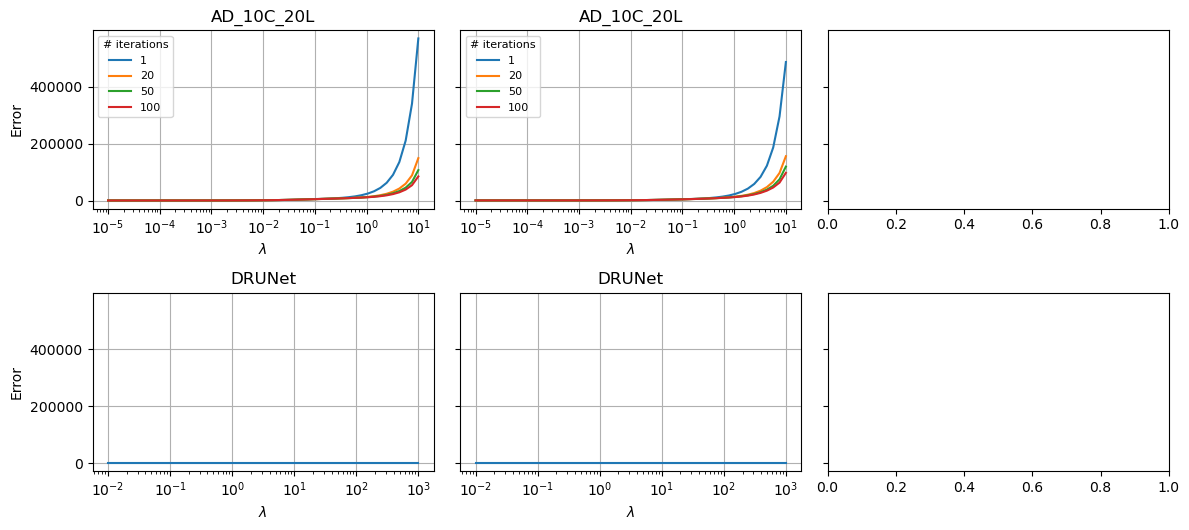

In [ ]:
n_plots = len(base_names)
n_img = len(indices)
n_rep_list = [20, 50, 100]

fig_lambda, axs_lambda = plt.subplots(
    n_plots+1, n_img, sharey=True, figsize=(4*n_img, 3*(n_plots+1))
)

for i, results in enumerate(list_results):
    
    x_observed = results["observation"].transpose(1, 2, 0).clip(0, 1)
    img = results["truth"].transpose(1, 2, 0).clip(0, 1)
    #psnr = peak_signal_noise_ratio(img, x_observed.astype(np.float32))
    
    for k, base_name in enumerate(base_names):

        for rep in [1] + n_rep_list:
            
            name = f"{base_name}_{rep}R"
            res = results[name]
            axs_lambda[k, i].semilogx(res["lambda_list"], res['error'], label=rep)
        
        axs_lambda[k, i].set_title(f"{base_name}")
        axs_lambda[k, i].grid(True)
        #axs_lambda[k, i].axhline(y=psnr, linestyle='--', alpha=0.5, color="grey")
        axs_lambda[k, i].legend(title="# iterations", fontsize=8, title_fontsize=8)
        axs_lambda[k, i].set_xlabel(rf"$\lambda$")
    
    name = "DRUNet"
    res = results[name]
    axs_lambda[-1, i].semilogx(res["lambda_list"], res['error'])
    axs_lambda[-1, i].set_title(f"{name}")
    axs_lambda[-1, i].grid(True)
    axs_lambda[-1, i].axhline(y=psnr, linestyle='--', alpha=0.5, color="grey")
    axs_lambda[-1, i].set_xlabel(rf"$\lambda$")

for ax in axs_lambda[:, 0]:
    ax.set_ylabel("Error")
fig_lambda.tight_layout(rect=[0, 0, 1, 0.9])
name_std = f"{STD_NOISE}".replace(".", "")

In [13]:
STD_NOISE = 0.3
pth_kernel = "blur_models/no_blur.mat"
#pth_kernel = "blur_models/blur_3.mat"

dataloader = create_dataloader(
    DATA_PATH,
    min_sigma_noise=STD_NOISE,
    max_sigma_noise=STD_NOISE,
    device=DEVICE,
    dtype=torch.float,
    mini_batch_size=1,
    train=False,
    color=COLOR,
    fixed_noise=True,
    crop=False,
)

base_names = [
    # "SD_10C_1L",
    # "SD_10C_20L",
    # "SD_50C_1L",
    # "SD_50C_20L",
    # "SD_100C_1L",
    # "SD_100C_20L",
    "AD_10C_1L",
    "AD_10C_20L",
    # "AD_50C_1L",
    # "AD_50C_20L",
    # "AD_100C_1L",
    # "AD_100C_20L",
]
sublist_denoisers = ["DRUNet"] + [denoiser for denoiser in DENOISERS.keys() if any(base_name in denoiser for base_name in base_names)]

indices = [0,1]#,2]
list_results = []
for i in indices:
    print(f"Processing image {i}...")
    img = dataloader.dataset[i][1].cpu().numpy()
    img_noise = dataloader.dataset[i][0].cpu().numpy()
    results = generate_results_pnp(pth_kernel, img, n_iter_per_lambda=1, n_lambda=50)
    list_results.append(results)

Processing image 0...


100%|██████████| 50/50 [00:10<00:00,  4.97it/s]


Processing image 1...


100%|██████████| 50/50 [00:10<00:00,  4.88it/s]


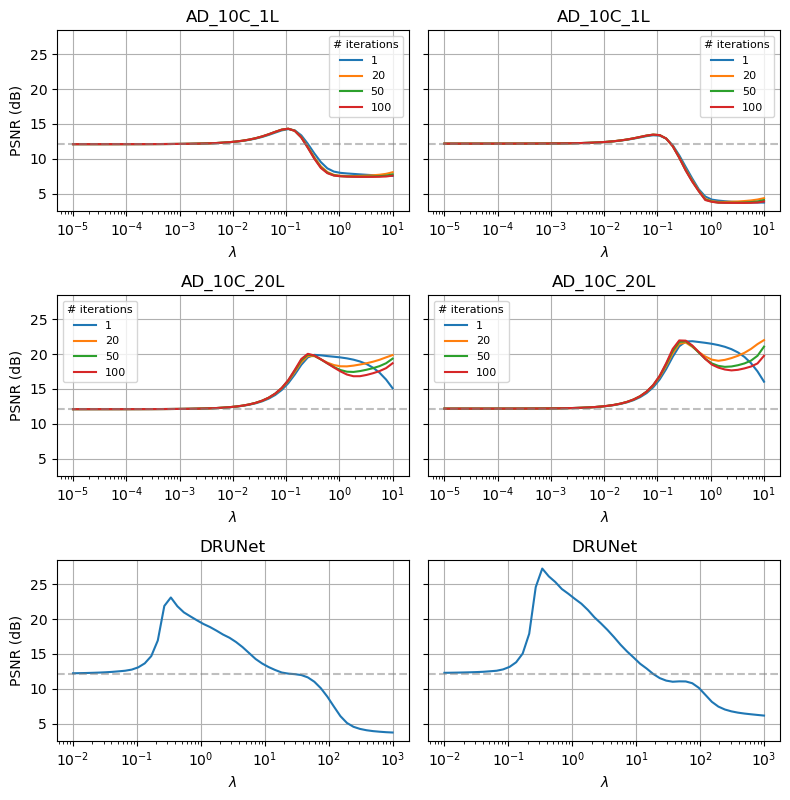

In [14]:
n_plots = len(base_names)
n_img = len(indices)
n_rep_list = [20, 50, 100]

fig_lambda, axs_lambda = plt.subplots(
    n_plots+1, n_img, sharey=True, figsize=(4*n_img, 3*(n_plots+1))
)

for i, results in enumerate(list_results):
    
    x_observed = results["observation"].transpose(1, 2, 0).clip(0, 1)
    img = results["truth"].transpose(1, 2, 0).clip(0, 1)
    psnr = peak_signal_noise_ratio(img, x_observed.astype(np.float32))
    
    for k, base_name in enumerate(base_names):

        for rep in [1] + n_rep_list:
            
            name = f"{base_name}_{rep}R"
            res = results[name]
            axs_lambda[k, i].semilogx(res["lambda_list"], res['psnr'], label=rep)
        
        axs_lambda[k, i].set_title(f"{base_name}")
        axs_lambda[k, i].grid(True)
        axs_lambda[k, i].axhline(y=psnr, linestyle='--', alpha=0.5, color="grey")
        axs_lambda[k, i].legend(title="# iterations", fontsize=8, title_fontsize=8)
        axs_lambda[k, i].set_xlabel(rf"$\lambda$")
    
    name = "DRUNet"
    res = results[name]
    axs_lambda[-1, i].semilogx(res["lambda_list"], res['psnr'])
    axs_lambda[-1, i].set_title(f"{name}")
    axs_lambda[-1, i].grid(True)
    axs_lambda[-1, i].axhline(y=psnr, linestyle='--', alpha=0.5, color="grey")
    axs_lambda[-1, i].set_xlabel(rf"$\lambda$")

for ax in axs_lambda[:, 0]:
    ax.set_ylabel("PSNR (dB)")
fig_lambda.tight_layout(rect=[0, 0, 1, 0.9])
name_std = f"{STD_NOISE}".replace(".", "")
#fig_lambda.savefig(f"warm_restart_denoising_{name_std}.pdf", bbox_inches="tight")

## Denoising

### Warm-restart

#### $\sigma = 0.1$

In [55]:
STD_NOISE = 0.1
pth_kernel = "blur_models/no_blur.mat"
#pth_kernel = "blur_models/blur_3.mat"

dataloader = create_dataloader(
    DATA_PATH,
    min_sigma_noise=STD_NOISE,
    max_sigma_noise=STD_NOISE,
    device=DEVICE,
    dtype=torch.float,
    mini_batch_size=1,
    train=False,
    color=COLOR,
    fixed_noise=True,
    crop=False,
)

base_names = [
    "SD_10C_1L",
    "SD_10C_20L",
    "SD_50C_1L",
    "SD_50C_20L",
    "SD_100C_1L",
    "SD_100C_20L",
    "AD_10C_1L",
    "AD_10C_20L",
    "AD_50C_1L",
    "AD_50C_20L",
    "AD_100C_1L",
    "AD_100C_20L",
]
sublist_denoisers = ["DRUNet"] + [denoiser for denoiser in DENOISERS.keys() if any(base_name in denoiser for base_name in base_names)]

indices = [0,1,2]
list_results = []
for i in indices:
    print(f"Processing image {i}...")
    img = dataloader.dataset[i][1].cpu().numpy()
    img_noise = dataloader.dataset[i][0].cpu().numpy()
    results = generate_results_pnp_warm_restart(pth_kernel, img, n_iter_per_lambda=1, n_lambda=50)
    list_results.append(results)

Processing image 0...


100%|██████████| 50/50 [00:21<00:00,  2.36it/s]


Processing image 1...


100%|██████████| 50/50 [00:21<00:00,  2.35it/s]


Processing image 2...


100%|██████████| 50/50 [00:21<00:00,  2.36it/s]


In [56]:
name_std = f"{STD_NOISE}".replace(".", "")
with open(f"warm_restart/results_denoising_{name_std}.pkl", "wb") as f:
    pickle.dump(list_results, f)

In [ ]:
n_plots = len(base_names)
n_img = len(indices)

fig_lambda, axs_lambda = plt.subplots(
    n_plots+1, n_img, sharey=True, figsize=(4*n_img, 3*(n_plots+1))
)

for i, results in enumerate(list_results):
    
    x_observed = results["observation"].transpose(1, 2, 0).clip(0, 1)
    img = results["truth"].transpose(1, 2, 0).clip(0, 1)
    psnr = peak_signal_noise_ratio(img, x_observed.astype(np.float32))
    
    for k, base_name in enumerate(base_names):

        for rep in [1] + n_rep_list:
            
            name = f"{base_name}_{rep}R"
            res = results[name]
            axs_lambda[k, i].semilogx(res["lambda_list"], res['psnr'], label=rep)
        
        axs_lambda[k, i].set_title(f"{base_name}")
        axs_lambda[k, i].grid(True)
        axs_lambda[k, i].axhline(y=psnr, linestyle='--', alpha=0.5, color="grey")
        axs_lambda[k, i].legend(title="# iterations", fontsize=8, title_fontsize=8)
        axs_lambda[k, i].set_xlabel(rf"$\lambda$")
    
    name = "DRUNet"
    res = results[name]
    axs_lambda[-1, i].semilogx(res["lambda_list"], res['psnr'])
    axs_lambda[-1, i].set_title(f"{name}")
    axs_lambda[-1, i].grid(True)
    axs_lambda[-1, i].axhline(y=psnr, linestyle='--', alpha=0.5, color="grey")
    axs_lambda[-1, i].set_xlabel(rf"$\lambda$")

for ax in axs_lambda[:, 0]:
    ax.set_ylabel("PSNR (dB)")
fig_lambda.tight_layout(rect=[0, 0, 1, 0.9])
name_std = f"{STD_NOISE}".replace(".", "")
fig_lambda.savefig(f"warm_restart_denoising_{name_std}.pdf", bbox_inches="tight")

#### $\sigma = 0.2$

In [58]:
STD_NOISE = 0.2
pth_kernel = "blur_models/no_blur.mat"
#pth_kernel = "blur_models/blur_3.mat"

dataloader = create_dataloader(
    DATA_PATH,
    min_sigma_noise=STD_NOISE,
    max_sigma_noise=STD_NOISE,
    device=DEVICE,
    dtype=torch.float,
    mini_batch_size=1,
    train=False,
    color=COLOR,
    fixed_noise=True,
    crop=False,
)

base_names = [
    "SD_10C_1L",
    "SD_10C_20L",
    "SD_50C_1L",
    "SD_50C_20L",
    "SD_100C_1L",
    "SD_100C_20L",
    "AD_10C_1L",
    "AD_10C_20L",
    "AD_50C_1L",
    "AD_50C_20L",
    "AD_100C_1L",
    "AD_100C_20L",
]
sublist_denoisers = ["DRUNet"] + [denoiser for denoiser in DENOISERS.keys() if any(base_name in denoiser for base_name in base_names)]

indices = [0,1,2]
list_results = []
for i in indices:
    print(f"Processing image {i}...")
    img = dataloader.dataset[i][1].cpu().numpy()
    img_noise = dataloader.dataset[i][0].cpu().numpy()
    results = generate_results_pnp_warm_restart(pth_kernel, img, n_iter_per_lambda=1, n_lambda=50)
    list_results.append(results)

Processing image 0...


100%|██████████| 50/50 [00:21<00:00,  2.36it/s]


Processing image 1...


100%|██████████| 50/50 [00:21<00:00,  2.35it/s]


Processing image 2...


100%|██████████| 50/50 [00:21<00:00,  2.36it/s]


In [59]:
name_std = f"{STD_NOISE}".replace(".", "")
with open(f"warm_restart/results_denoising_{name_std}.pkl", "wb") as f:
    pickle.dump(list_results, f)

In [ ]:
n_plots = len(base_names)
n_img = len(indices)

fig_lambda, axs_lambda = plt.subplots(
    n_plots+1, n_img, sharey=True, figsize=(4*n_img, 3*(n_plots+1))
)

for i, results in enumerate(list_results):
    
    x_observed = results["observation"].transpose(1, 2, 0).clip(0, 1)
    img = results["truth"].transpose(1, 2, 0).clip(0, 1)
    psnr = peak_signal_noise_ratio(img, x_observed.astype(np.float32))
    
    for k, base_name in enumerate(base_names):

        for rep in [1] + n_rep_list:
            
            name = f"{base_name}_{rep}R"
            res = results[name]
            axs_lambda[k, i].semilogx(res["lambda_list"], res['psnr'], label=rep)
        
        axs_lambda[k, i].set_title(f"{base_name}")
        axs_lambda[k, i].grid(True)
        axs_lambda[k, i].axhline(y=psnr, linestyle='--', alpha=0.5, color="grey")
        axs_lambda[k, i].legend(title="# iterations", fontsize=8, title_fontsize=8)
        axs_lambda[k, i].set_xlabel(rf"$\lambda$")
    
    name = "DRUNet"
    res = results[name]
    axs_lambda[-1, i].semilogx(res["lambda_list"], res['psnr'])
    axs_lambda[-1, i].set_title(f"{name}")
    axs_lambda[-1, i].grid(True)
    axs_lambda[-1, i].axhline(y=psnr, linestyle='--', alpha=0.5, color="grey")
    axs_lambda[-1, i].set_xlabel(rf"$\lambda$")

for ax in axs_lambda[:, 0]:
    ax.set_ylabel("PSNR (dB)")
fig_lambda.tight_layout(rect=[0, 0, 1, 0.9])
name_std = f"{STD_NOISE}".replace(".", "")
fig_lambda.savefig(f"warm_restart_denoising_{name_std}.pdf", bbox_inches="tight")

#### $\sigma = 0.5$

In [61]:
STD_NOISE = 0.5
pth_kernel = "blur_models/no_blur.mat"
#pth_kernel = "blur_models/blur_3.mat"

dataloader = create_dataloader(
    DATA_PATH,
    min_sigma_noise=STD_NOISE,
    max_sigma_noise=STD_NOISE,
    device=DEVICE,
    dtype=torch.float,
    mini_batch_size=1,
    train=False,
    color=COLOR,
    fixed_noise=True,
    crop=False,
)

base_names = [
    "SD_10C_1L",
    "SD_10C_20L",
    "SD_50C_1L",
    "SD_50C_20L",
    "SD_100C_1L",
    "SD_100C_20L",
    "AD_10C_1L",
    "AD_10C_20L",
    "AD_50C_1L",
    "AD_50C_20L",
    "AD_100C_1L",
    "AD_100C_20L",
]
sublist_denoisers = ["DRUNet"] + [denoiser for denoiser in DENOISERS.keys() if any(base_name in denoiser for base_name in base_names)]

indices = [0,1,2]
list_results = []
for i in indices:
    print(f"Processing image {i}...")
    img = dataloader.dataset[i][1].cpu().numpy()
    img_noise = dataloader.dataset[i][0].cpu().numpy()
    results = generate_results_pnp_warm_restart(pth_kernel, img, n_iter_per_lambda=1, n_lambda=50)
    list_results.append(results)

Processing image 0...


 14%|█▍        | 7/50 [00:00<00:05,  7.92it/s]

100%|██████████| 50/50 [00:21<00:00,  2.37it/s]


Processing image 1...


100%|██████████| 50/50 [00:21<00:00,  2.37it/s]


Processing image 2...


100%|██████████| 50/50 [00:21<00:00,  2.37it/s]


In [62]:
name_std = f"{STD_NOISE}".replace(".", "")
with open(f"warm_restart/results_denoising_{name_std}.pkl", "wb") as f:
    pickle.dump(list_results, f)

In [ ]:
n_plots = len(base_names)
n_img = len(indices)

fig_lambda, axs_lambda = plt.subplots(
    n_plots+1, n_img, sharey=True, figsize=(4*n_img, 3*(n_plots+1))
)

for i, results in enumerate(list_results):
    
    x_observed = results["observation"].transpose(1, 2, 0).clip(0, 1)
    img = results["truth"].transpose(1, 2, 0).clip(0, 1)
    psnr = peak_signal_noise_ratio(img, x_observed.astype(np.float32))
    
    for k, base_name in enumerate(base_names):

        for rep in [1] + n_rep_list:
            
            name = f"{base_name}_{rep}R"
            res = results[name]
            axs_lambda[k, i].semilogx(res["lambda_list"], res['psnr'], label=rep)
        
        axs_lambda[k, i].set_title(f"{base_name}")
        axs_lambda[k, i].grid(True)
        axs_lambda[k, i].axhline(y=psnr, linestyle='--', alpha=0.5, color="grey")
        axs_lambda[k, i].legend(title="# iterations", fontsize=8, title_fontsize=8)
        axs_lambda[k, i].set_xlabel(rf"$\lambda$")
    
    name = "DRUNet"
    res = results[name]
    axs_lambda[-1, i].semilogx(res["lambda_list"], res['psnr'])
    axs_lambda[-1, i].set_title(f"{name}")
    axs_lambda[-1, i].grid(True)
    axs_lambda[-1, i].axhline(y=psnr, linestyle='--', alpha=0.5, color="grey")
    axs_lambda[-1, i].set_xlabel(rf"$\lambda$")

for ax in axs_lambda[:, 0]:
    ax.set_ylabel("PSNR (dB)")
fig_lambda.tight_layout(rect=[0, 0, 1, 0.9])
name_std = f"{STD_NOISE}".replace(".", "")
fig_lambda.savefig(f"warm_restart_denoising_{name_std}.pdf", bbox_inches="tight")

#### $\sigma = 2.0$

In [64]:
STD_NOISE = 2.0
pth_kernel = "blur_models/no_blur.mat"
#pth_kernel = "blur_models/blur_3.mat"

dataloader = create_dataloader(
    DATA_PATH,
    min_sigma_noise=STD_NOISE,
    max_sigma_noise=STD_NOISE,
    device=DEVICE,
    dtype=torch.float,
    mini_batch_size=1,
    train=False,
    color=COLOR,
    fixed_noise=True,
    crop=False,
)

base_names = [
    "SD_10C_1L",
    "SD_10C_20L",
    "SD_50C_1L",
    "SD_50C_20L",
    "SD_100C_1L",
    "SD_100C_20L",
    "AD_10C_1L",
    "AD_10C_20L",
    "AD_50C_1L",
    "AD_50C_20L",
    "AD_100C_1L",
    "AD_100C_20L",
]
sublist_denoisers = ["DRUNet"] + [denoiser for denoiser in DENOISERS.keys() if any(base_name in denoiser for base_name in base_names)]

indices = [0,1,2]
list_results = []
for i in indices:
    print(f"Processing image {i}...")
    img = dataloader.dataset[i][1].cpu().numpy()
    img_noise = dataloader.dataset[i][0].cpu().numpy()
    results = generate_results_pnp_warm_restart(pth_kernel, img, n_iter_per_lambda=1, n_lambda=50)
    list_results.append(results)

Processing image 0...


  6%|▌         | 3/50 [00:00<00:05,  7.97it/s]

100%|██████████| 50/50 [00:21<00:00,  2.37it/s]


Processing image 1...


100%|██████████| 50/50 [00:21<00:00,  2.36it/s]


Processing image 2...


100%|██████████| 50/50 [00:21<00:00,  2.37it/s]


In [65]:
name_std = f"{STD_NOISE}".replace(".", "")
with open(f"warm_restart/results_denoising_{name_std}.pkl", "wb") as f:
    pickle.dump(list_results, f)

In [ ]:
n_plots = len(base_names)
n_img = len(indices)

fig_lambda, axs_lambda = plt.subplots(
    n_plots+1, n_img, sharey=True, figsize=(4*n_img, 3*(n_plots+1))
)

for i, results in enumerate(list_results):
    
    x_observed = results["observation"].transpose(1, 2, 0).clip(0, 1)
    img = results["truth"].transpose(1, 2, 0).clip(0, 1)
    psnr = peak_signal_noise_ratio(img, x_observed.astype(np.float32))
    
    for k, base_name in enumerate(base_names):

        for rep in [1] + n_rep_list:
            
            name = f"{base_name}_{rep}R"
            res = results[name]
            axs_lambda[k, i].semilogx(res["lambda_list"], res['psnr'], label=rep)
        
        axs_lambda[k, i].set_title(f"{base_name}")
        axs_lambda[k, i].grid(True)
        axs_lambda[k, i].axhline(y=psnr, linestyle='--', alpha=0.5, color="grey")
        axs_lambda[k, i].legend(title="# iterations", fontsize=8, title_fontsize=8)
        axs_lambda[k, i].set_xlabel(rf"$\lambda$")
    
    name = "DRUNet"
    res = results[name]
    axs_lambda[-1, i].semilogx(res["lambda_list"], res['psnr'])
    axs_lambda[-1, i].set_title(f"{name}")
    axs_lambda[-1, i].grid(True)
    axs_lambda[-1, i].axhline(y=psnr, linestyle='--', alpha=0.5, color="grey")
    axs_lambda[-1, i].set_xlabel(rf"$\lambda$")

for ax in axs_lambda[:, 0]:
    ax.set_ylabel("PSNR (dB)")
fig_lambda.tight_layout(rect=[0, 0, 1, 0.9])
name_std = f"{STD_NOISE}".replace(".", "")
fig_lambda.savefig(f"warm_restart_denoising_{name_std}.pdf", bbox_inches="tight")

### No warm-restart

#### $\sigma=0.1$

In [9]:
STD_NOISE = 0.1
pth_kernel = "blur_models/no_blur.mat"
#pth_kernel = "blur_models/blur_3.mat"

dataloader = create_dataloader(
    DATA_PATH,
    min_sigma_noise=STD_NOISE,
    max_sigma_noise=STD_NOISE,
    device=DEVICE,
    dtype=torch.float,
    mini_batch_size=1,
    train=False,
    color=COLOR,
    fixed_noise=True,
    crop=False,
)

base_names = [
    "SD_10C_1L",
    "SD_10C_20L",
    "SD_50C_1L",
    "SD_50C_20L",
    "SD_100C_1L",
    "SD_100C_20L",
    "AD_10C_1L",
    "AD_10C_20L",
    "AD_50C_1L",
    "AD_50C_20L",
    "AD_100C_1L",
    "AD_100C_20L",
]
sublist_denoisers = ["DRUNet"] + [denoiser for denoiser in DENOISERS.keys() if any(base_name in denoiser for base_name in base_names)]

indices = [0,1,2]
list_results = []
for i in indices:
    print(f"Processing image {i}...")
    img = dataloader.dataset[i][1].cpu().numpy()
    img_noise = dataloader.dataset[i][0].cpu().numpy()
    results = generate_results_pnp(pth_kernel, img, n_iter_per_lambda=1, n_lambda=50, warm_restart=False)
    list_results.append(results)

Processing image 0...


  0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_90890/1597815931.py:51: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr_bis[i] = peak_signal_noise_ratio(x_n, x_observed)
100%|██████████| 50/50 [00:23<00:00,  2.15it/s]


Processing image 1...


100%|██████████| 50/50 [00:23<00:00,  2.17it/s]


Processing image 2...


100%|██████████| 50/50 [00:23<00:00,  2.15it/s]


In [10]:
name_std = f"{STD_NOISE}".replace(".", "")
with open(f"warm_restart/results_denoising_{name_std}_no_warm_restart.pkl", "wb") as f:
    pickle.dump(list_results, f)

In [ ]:
n_rep_list = [20, 50, 100]
n_plots = len(base_names)
n_img = len(indices)

fig_lambda, axs_lambda = plt.subplots(
    n_plots+1, n_img, sharey=True, figsize=(4*n_img, 3*(n_plots+1))
)

for i, results in enumerate(list_results):
    
    x_observed = results["observation"].transpose(1, 2, 0).clip(0, 1)
    img = results["truth"].transpose(1, 2, 0).clip(0, 1)
    psnr = peak_signal_noise_ratio(img, x_observed.astype(np.float32))
    
    for k, base_name in enumerate(base_names):

        for rep in [1] + n_rep_list:
            
            name = f"{base_name}_{rep}R"
            res = results[name]
            axs_lambda[k, i].semilogx(res["lambda_list"], res['psnr'], label=rep)
        
        axs_lambda[k, i].set_title(f"{base_name}")
        axs_lambda[k, i].grid(True)
        axs_lambda[k, i].axhline(y=psnr, linestyle='--', alpha=0.5, color="grey")
        axs_lambda[k, i].legend(title="# iterations", fontsize=8, title_fontsize=8)
        axs_lambda[k, i].set_xlabel(rf"$\lambda$")
    
    name = "DRUNet"
    res = results[name]
    axs_lambda[-1, i].semilogx(res["lambda_list"], res['psnr'])
    axs_lambda[-1, i].set_title(f"{name}")
    axs_lambda[-1, i].grid(True)
    axs_lambda[-1, i].axhline(y=psnr, linestyle='--', alpha=0.5, color="grey")
    axs_lambda[-1, i].set_xlabel(rf"$\lambda$")

for ax in axs_lambda[:, 0]:
    ax.set_ylabel("PSNR (dB)")
fig_lambda.tight_layout(rect=[0, 0, 1, 0.9])
name_std = f"{STD_NOISE}".replace(".", "")
plt.savefig(f"no_warm_restart_denoising_{name_std}.pdf", bbox_inches="tight")

#### $\sigma=0.2$

In [17]:
STD_NOISE = 0.2
pth_kernel = "blur_models/no_blur.mat"
#pth_kernel = "blur_models/blur_3.mat"

dataloader = create_dataloader(
    DATA_PATH,
    min_sigma_noise=STD_NOISE,
    max_sigma_noise=STD_NOISE,
    device=DEVICE,
    dtype=torch.float,
    mini_batch_size=1,
    train=False,
    color=COLOR,
    fixed_noise=True,
    crop=False,
)

base_names = [
    "SD_10C_1L",
    "SD_10C_20L",
    "SD_50C_1L",
    "SD_50C_20L",
    "SD_100C_1L",
    "SD_100C_20L",
    "AD_10C_1L",
    "AD_10C_20L",
    "AD_50C_1L",
    "AD_50C_20L",
    "AD_100C_1L",
    "AD_100C_20L",
]
sublist_denoisers = ["DRUNet"] + [denoiser for denoiser in DENOISERS.keys() if any(base_name in denoiser for base_name in base_names)]

indices = [0,1,2]
list_results = []
for i in indices:
    print(f"Processing image {i}...")
    img = dataloader.dataset[i][1].cpu().numpy()
    img_noise = dataloader.dataset[i][0].cpu().numpy()
    results = generate_results_pnp(pth_kernel, img, n_iter_per_lambda=1, n_lambda=50, warm_restart=False)
    list_results.append(results)

Processing image 0...


100%|██████████| 50/50 [00:23<00:00,  2.16it/s]


Processing image 1...


100%|██████████| 50/50 [00:23<00:00,  2.16it/s]


Processing image 2...


100%|██████████| 50/50 [00:23<00:00,  2.16it/s]


In [18]:
name_std = f"{STD_NOISE}".replace(".", "")
with open(f"warm_restart/results_denoising_{name_std}_no_warm_restart.pkl", "wb") as f:
    pickle.dump(list_results, f)

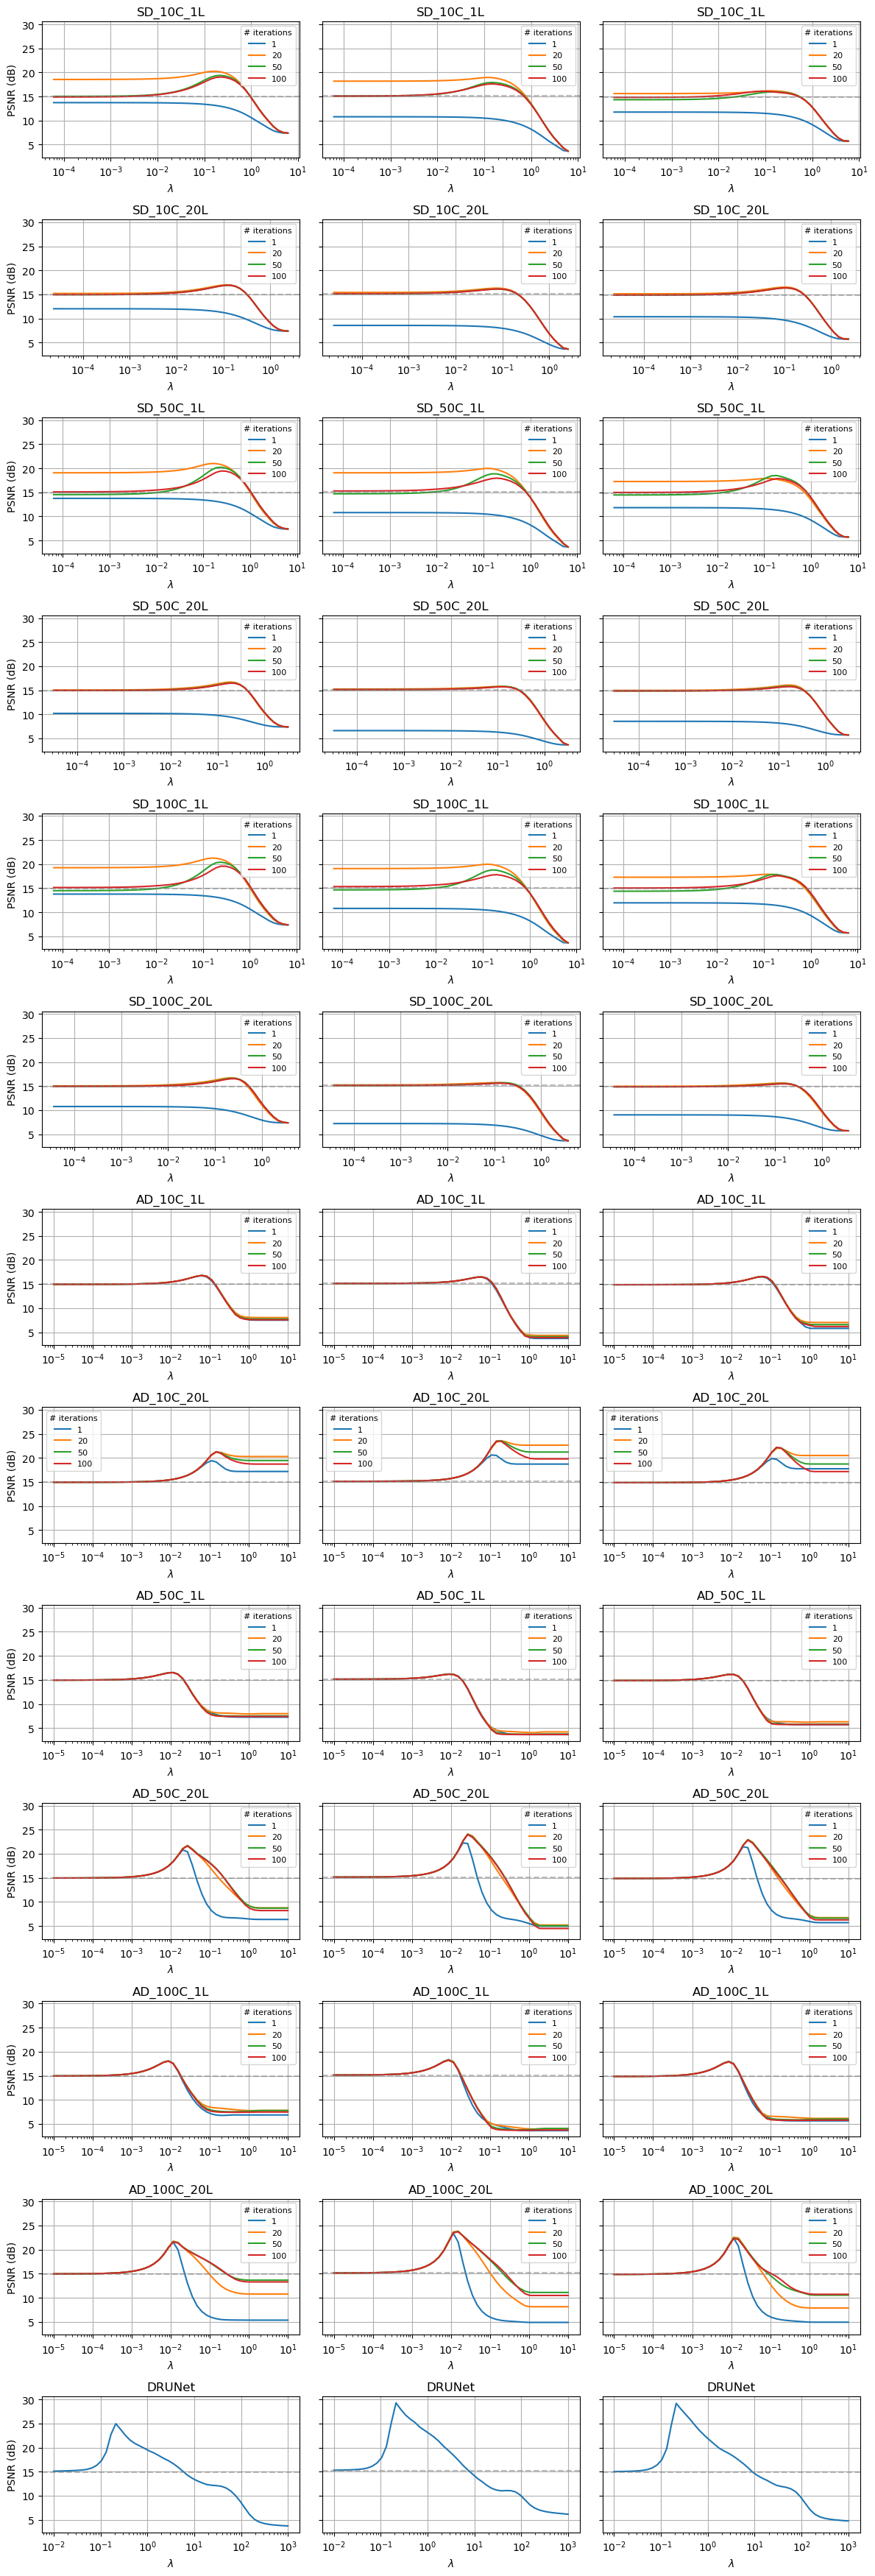

In [19]:
n_plots = len(base_names)
n_img = len(indices)

fig_lambda, axs_lambda = plt.subplots(
    n_plots+1, n_img, sharey=True, figsize=(4*n_img, 3*(n_plots+1))
)

for i, results in enumerate(list_results):
    
    x_observed = results["observation"].transpose(1, 2, 0).clip(0, 1)
    img = results["truth"].transpose(1, 2, 0).clip(0, 1)
    psnr = peak_signal_noise_ratio(img, x_observed.astype(np.float32))
    
    for k, base_name in enumerate(base_names):

        for rep in [1] + n_rep_list:
            
            name = f"{base_name}_{rep}R"
            res = results[name]
            axs_lambda[k, i].semilogx(res["lambda_list"], res['psnr'], label=rep)
        
        axs_lambda[k, i].set_title(f"{base_name}")
        axs_lambda[k, i].grid(True)
        axs_lambda[k, i].axhline(y=psnr, linestyle='--', alpha=0.5, color="grey")
        axs_lambda[k, i].legend(title="# iterations", fontsize=8, title_fontsize=8)
        axs_lambda[k, i].set_xlabel(rf"$\lambda$")
    
    name = "DRUNet"
    res = results[name]
    axs_lambda[-1, i].semilogx(res["lambda_list"], res['psnr'])
    axs_lambda[-1, i].set_title(f"{name}")
    axs_lambda[-1, i].grid(True)
    axs_lambda[-1, i].axhline(y=psnr, linestyle='--', alpha=0.5, color="grey")
    axs_lambda[-1, i].set_xlabel(rf"$\lambda$")

for ax in axs_lambda[:, 0]:
    ax.set_ylabel("PSNR (dB)")
fig_lambda.tight_layout(rect=[0, 0, 1, 0.9])
name_std = f"{STD_NOISE}".replace(".", "")
plt.savefig(f"no_warm_restart_denoising_{name_std}.pdf", bbox_inches="tight")

#### $\sigma=0.5$

In [20]:
STD_NOISE = 0.5
pth_kernel = "blur_models/no_blur.mat"
#pth_kernel = "blur_models/blur_3.mat"

dataloader = create_dataloader(
    DATA_PATH,
    min_sigma_noise=STD_NOISE,
    max_sigma_noise=STD_NOISE,
    device=DEVICE,
    dtype=torch.float,
    mini_batch_size=1,
    train=False,
    color=COLOR,
    fixed_noise=True,
    crop=False,
)

base_names = [
    "SD_10C_1L",
    "SD_10C_20L",
    "SD_50C_1L",
    "SD_50C_20L",
    "SD_100C_1L",
    "SD_100C_20L",
    "AD_10C_1L",
    "AD_10C_20L",
    "AD_50C_1L",
    "AD_50C_20L",
    "AD_100C_1L",
    "AD_100C_20L",
]
sublist_denoisers = ["DRUNet"] + [denoiser for denoiser in DENOISERS.keys() if any(base_name in denoiser for base_name in base_names)]

indices = [0,1,2]
list_results = []
for i in indices:
    print(f"Processing image {i}...")
    img = dataloader.dataset[i][1].cpu().numpy()
    img_noise = dataloader.dataset[i][0].cpu().numpy()
    results = generate_results_pnp(pth_kernel, img, n_iter_per_lambda=1, n_lambda=50, warm_restart=False)
    list_results.append(results)

Processing image 0...


100%|██████████| 50/50 [00:23<00:00,  2.16it/s]


Processing image 1...


100%|██████████| 50/50 [00:23<00:00,  2.16it/s]


Processing image 2...


100%|██████████| 50/50 [00:22<00:00,  2.18it/s]


In [21]:
name_std = f"{STD_NOISE}".replace(".", "")
with open(f"warm_restart/results_denoising_{name_std}_no_warm_restart.pkl", "wb") as f:
    pickle.dump(list_results, f)

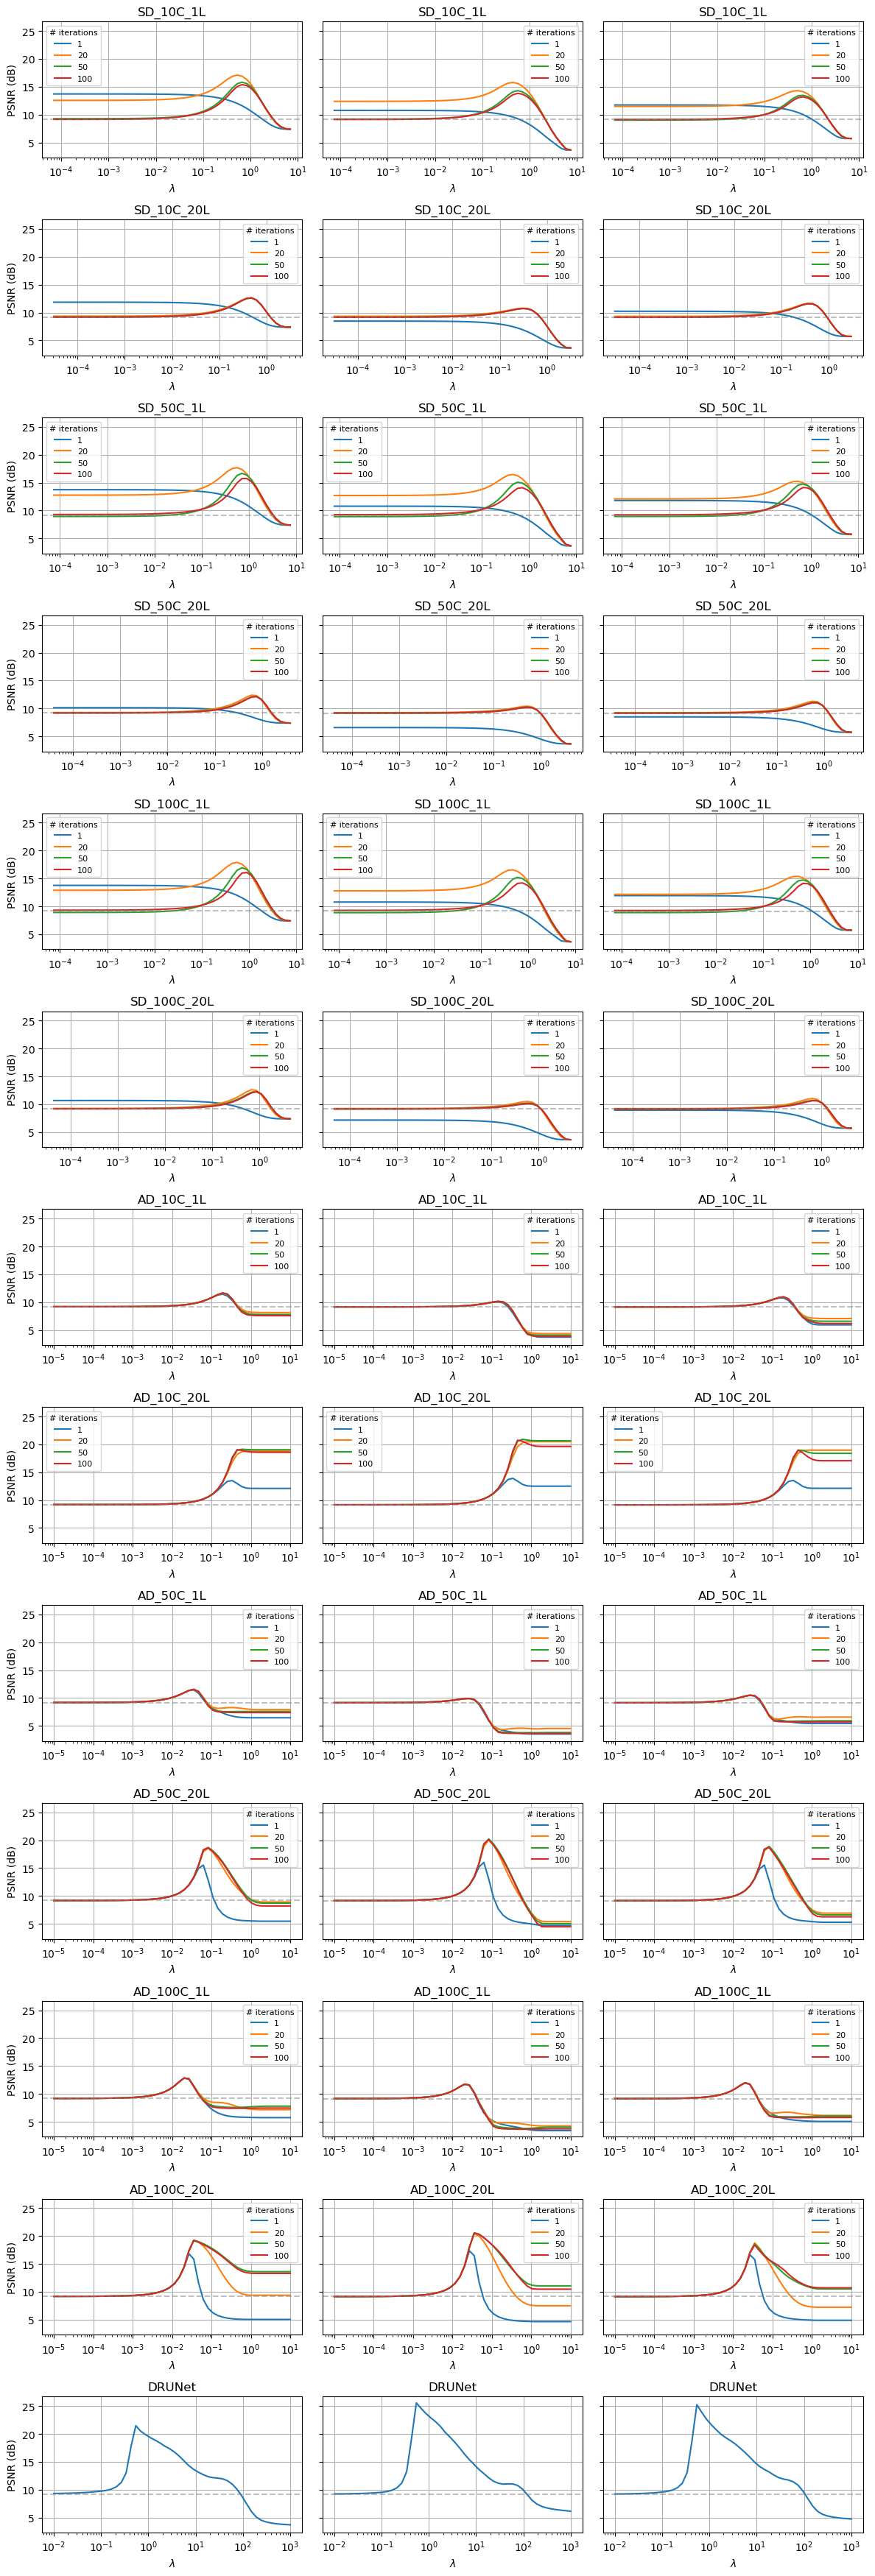

In [22]:
n_plots = len(base_names)
n_img = len(indices)

fig_lambda, axs_lambda = plt.subplots(
    n_plots+1, n_img, sharey=True, figsize=(4*n_img, 3*(n_plots+1))
)

for i, results in enumerate(list_results):
    
    x_observed = results["observation"].transpose(1, 2, 0).clip(0, 1)
    img = results["truth"].transpose(1, 2, 0).clip(0, 1)
    psnr = peak_signal_noise_ratio(img, x_observed.astype(np.float32))
    
    for k, base_name in enumerate(base_names):

        for rep in [1] + n_rep_list:
            
            name = f"{base_name}_{rep}R"
            res = results[name]
            axs_lambda[k, i].semilogx(res["lambda_list"], res['psnr'], label=rep)
        
        axs_lambda[k, i].set_title(f"{base_name}")
        axs_lambda[k, i].grid(True)
        axs_lambda[k, i].axhline(y=psnr, linestyle='--', alpha=0.5, color="grey")
        axs_lambda[k, i].legend(title="# iterations", fontsize=8, title_fontsize=8)
        axs_lambda[k, i].set_xlabel(rf"$\lambda$")
    
    name = "DRUNet"
    res = results[name]
    axs_lambda[-1, i].semilogx(res["lambda_list"], res['psnr'])
    axs_lambda[-1, i].set_title(f"{name}")
    axs_lambda[-1, i].grid(True)
    axs_lambda[-1, i].axhline(y=psnr, linestyle='--', alpha=0.5, color="grey")
    axs_lambda[-1, i].set_xlabel(rf"$\lambda$")

for ax in axs_lambda[:, 0]:
    ax.set_ylabel("PSNR (dB)")
fig_lambda.tight_layout(rect=[0, 0, 1, 0.9])
name_std = f"{STD_NOISE}".replace(".", "")
plt.savefig(f"no_warm_restart_denoising_{name_std}.pdf", bbox_inches="tight")

#### $\sigma=2.0$

In [23]:
STD_NOISE = 2.0
pth_kernel = "blur_models/no_blur.mat"
#pth_kernel = "blur_models/blur_3.mat"

dataloader = create_dataloader(
    DATA_PATH,
    min_sigma_noise=STD_NOISE,
    max_sigma_noise=STD_NOISE,
    device=DEVICE,
    dtype=torch.float,
    mini_batch_size=1,
    train=False,
    color=COLOR,
    fixed_noise=True,
    crop=False,
)

base_names = [
    "SD_10C_1L",
    "SD_10C_20L",
    "SD_50C_1L",
    "SD_50C_20L",
    "SD_100C_1L",
    "SD_100C_20L",
    "AD_10C_1L",
    "AD_10C_20L",
    "AD_50C_1L",
    "AD_50C_20L",
    "AD_100C_1L",
    "AD_100C_20L",
]
sublist_denoisers = ["DRUNet"] + [denoiser for denoiser in DENOISERS.keys() if any(base_name in denoiser for base_name in base_names)]

indices = [0,1,2]
list_results = []
for i in indices:
    print(f"Processing image {i}...")
    img = dataloader.dataset[i][1].cpu().numpy()
    img_noise = dataloader.dataset[i][0].cpu().numpy()
    results = generate_results_pnp(pth_kernel, img, n_iter_per_lambda=1, n_lambda=50, warm_restart=False)
    list_results.append(results)

Processing image 0...


100%|██████████| 50/50 [00:22<00:00,  2.19it/s]


Processing image 1...


100%|██████████| 50/50 [00:23<00:00,  2.17it/s]


Processing image 2...


100%|██████████| 50/50 [00:23<00:00,  2.16it/s]


In [24]:
name_std = f"{STD_NOISE}".replace(".", "")
with open(f"warm_restart/results_denoising_{name_std}_no_warm_restart.pkl", "wb") as f:
    pickle.dump(list_results, f)

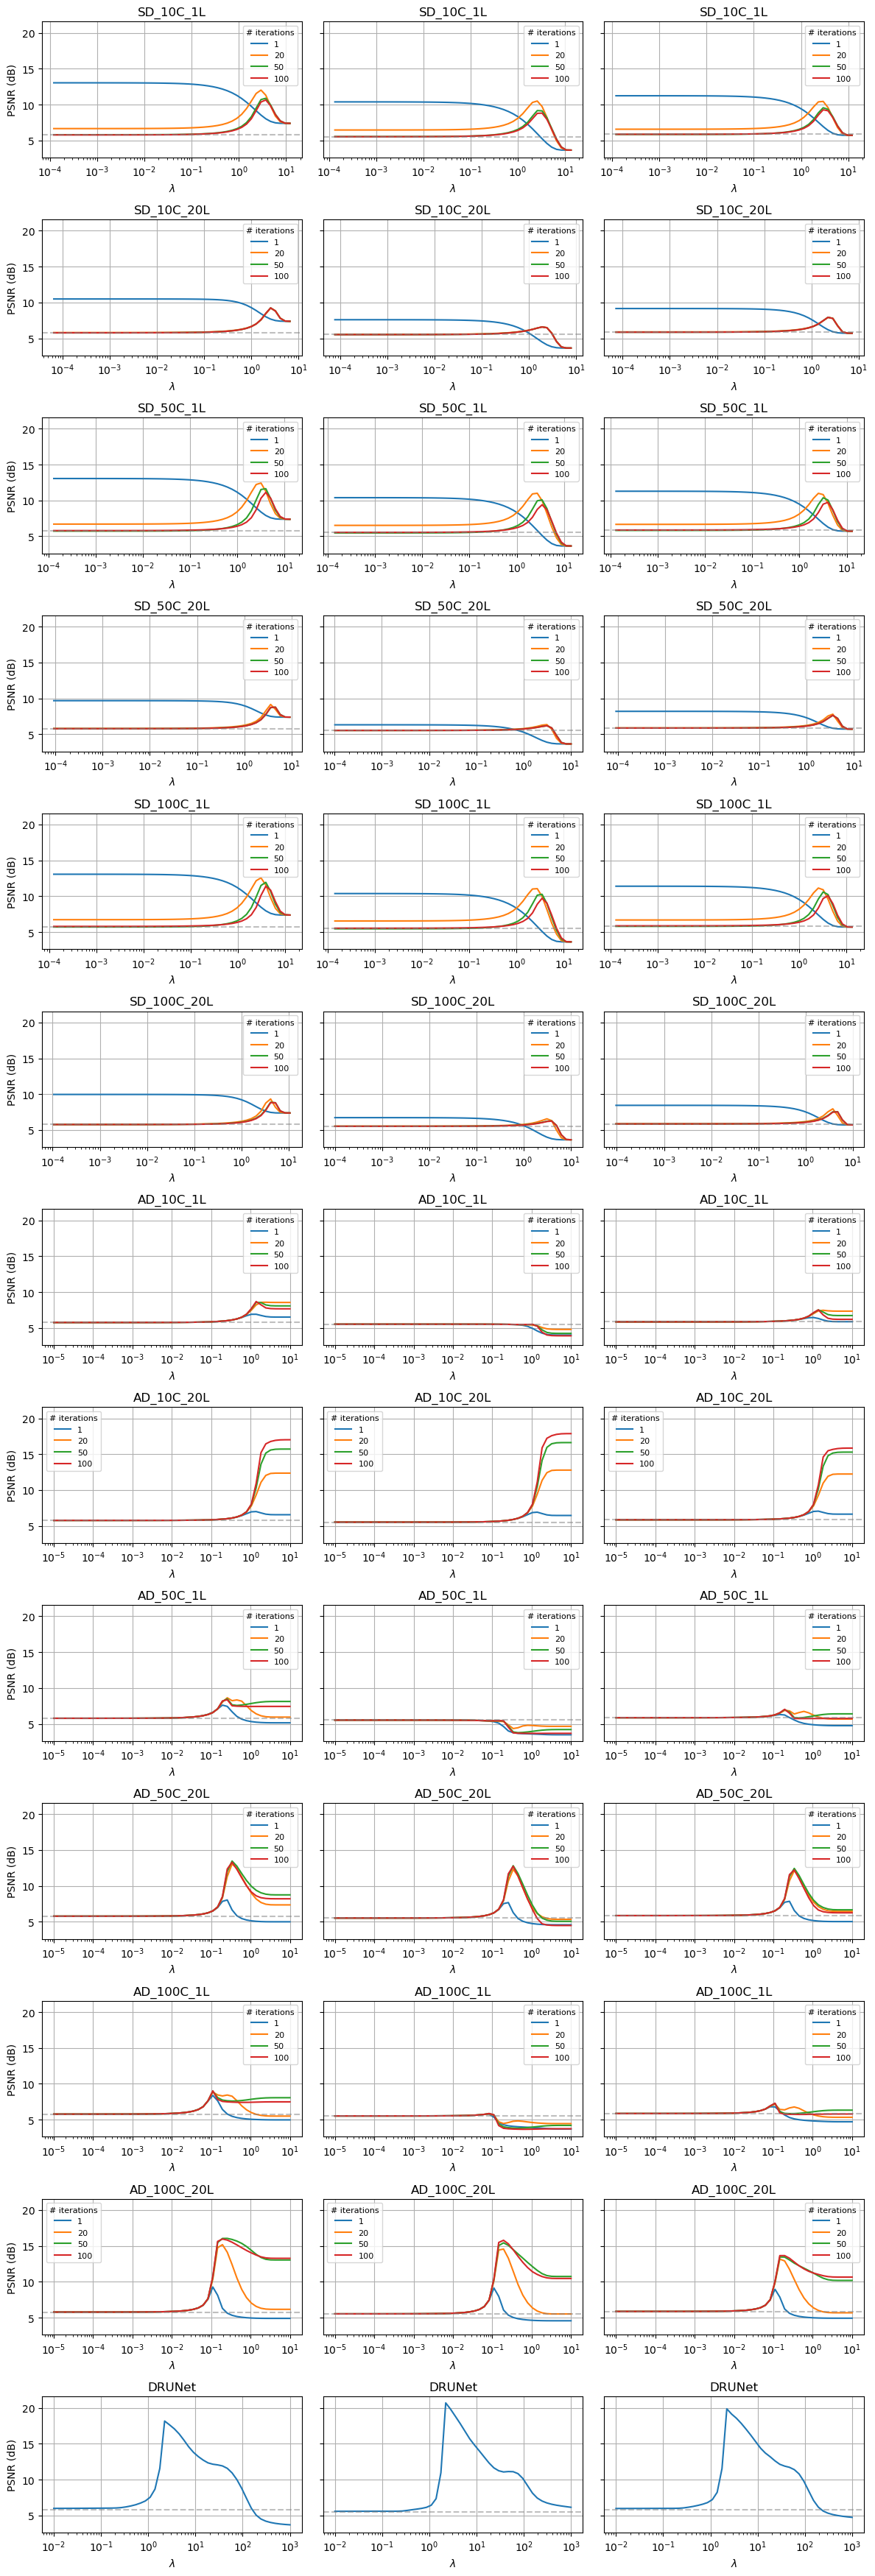

In [25]:
n_plots = len(base_names)
n_img = len(indices)

fig_lambda, axs_lambda = plt.subplots(
    n_plots+1, n_img, sharey=True, figsize=(4*n_img, 3*(n_plots+1))
)

for i, results in enumerate(list_results):
    
    x_observed = results["observation"].transpose(1, 2, 0).clip(0, 1)
    img = results["truth"].transpose(1, 2, 0).clip(0, 1)
    psnr = peak_signal_noise_ratio(img, x_observed.astype(np.float32))
    
    for k, base_name in enumerate(base_names):

        for rep in [1] + n_rep_list:
            
            name = f"{base_name}_{rep}R"
            res = results[name]
            axs_lambda[k, i].semilogx(res["lambda_list"], res['psnr'], label=rep)
        
        axs_lambda[k, i].set_title(f"{base_name}")
        axs_lambda[k, i].grid(True)
        axs_lambda[k, i].axhline(y=psnr, linestyle='--', alpha=0.5, color="grey")
        axs_lambda[k, i].legend(title="# iterations", fontsize=8, title_fontsize=8)
        axs_lambda[k, i].set_xlabel(rf"$\lambda$")
    
    name = "DRUNet"
    res = results[name]
    axs_lambda[-1, i].semilogx(res["lambda_list"], res['psnr'])
    axs_lambda[-1, i].set_title(f"{name}")
    axs_lambda[-1, i].grid(True)
    axs_lambda[-1, i].axhline(y=psnr, linestyle='--', alpha=0.5, color="grey")
    axs_lambda[-1, i].set_xlabel(rf"$\lambda$")

for ax in axs_lambda[:, 0]:
    ax.set_ylabel("PSNR (dB)")
fig_lambda.tight_layout(rect=[0, 0, 1, 0.9])
name_std = f"{STD_NOISE}".replace(".", "")
plt.savefig(f"no_warm_restart_denoising_{name_std}.pdf", bbox_inches="tight")

## Deblurring

In [13]:
STD_NOISE = 0.1
#pth_kernel = "blur_models/no_blur.mat"
pth_kernel = "blur_models/blur_3.mat"

dataloader = create_dataloader(
    DATA_PATH,
    min_sigma_noise=STD_NOISE,
    max_sigma_noise=STD_NOISE,
    device=DEVICE,
    dtype=torch.float,
    mini_batch_size=1,
    train=False,
    color=COLOR,
    fixed_noise=True,
    crop=False,
)

base_names = [
    # "SD_10C_1L",
    # "SD_10C_20L",
    # "SD_50C_1L",
    # "SD_50C_20L",
    # "SD_100C_1L",
    # "SD_100C_20L",
    "AD_10C_1L",
    "AD_10C_20L",
    # "AD_50C_1L",
    # "AD_50C_20L",
    # "AD_100C_1L",
    # "AD_100C_20L",
]



sublist_denoisers = ["DRUNet"] + [denoiser for denoiser in DENOISERS.keys() if any(base_name in denoiser for base_name in base_names)]
#sublist_denoisers = ["SD_10C_20L_1R", "SD_10C_20L_20R", "SD_10C_20L_50R", "SD_10C_20L_100R"]

indices = [1,3]#,2]
list_results = []
n_iter_per_lambda = 50
n_lambda = 50
eps_stop = 1e-4
for i in indices:
    print(f"Processing image {i}...")
    img = dataloader.dataset[i][1].cpu().numpy()
    img_noise = dataloader.dataset[i][0].cpu().numpy()
    results = generate_results_pnp(pth_kernel, img, n_iter_per_lambda=n_iter_per_lambda, n_lambda=n_lambda, eps_stop=eps_stop, lambda_start=1000)
    list_results.append(results)

Processing image 1...


  2%|▏         | 1/50 [00:10<08:52, 10.87s/it]


KeyboardInterrupt: 

In [ ]:
name_std = f"{STD_NOISE}".replace(".", "")
with open(f"warm_restart/results_deblurring_{name_std}.pkl", "wb") as f:
    pickle.dump(list_results, f)

In [15]:
# Load results
name_std = f"{STD_NOISE}".replace(".", "")
with open(f"warm_restart/results_deblurring_{name_std}.pkl", "rb") as f:
    list_results = pickle.load(f)

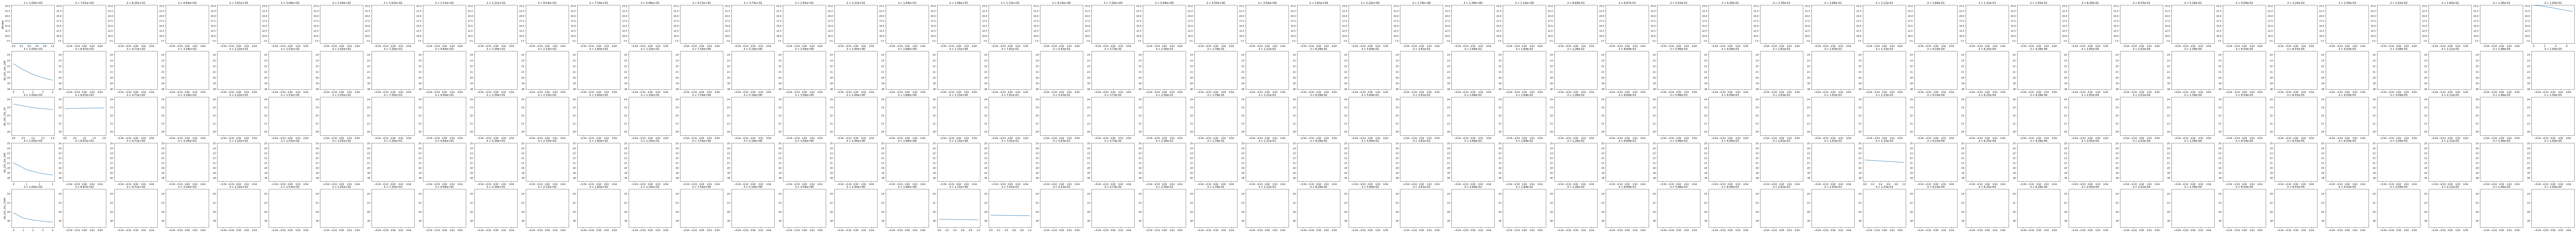

In [10]:
fig, axs = plt.subplots(len(sublist_denoisers), n_lambda, figsize=(4*n_lambda, 3.5*len(sublist_denoisers)))

for i in range(len(sublist_denoisers)):
    axs[i, 0].set_ylabel(sublist_denoisers[i])
    res = list_results[0][sublist_denoisers[i]]
    
    y_values = []  # Collect y-values for this row

    for j in range(n_lambda):
        y = res["psnr_bis"][res["stops"][j]:res["stops"][j+1]]
        axs[i, j].plot(y)
        axs[i, j].set_title(rf"$\lambda=${res['lambda_list'][j]:.2e}")
        y_values.extend(y)  # Gather for consistent y-axis
    
    # Set same y-limits for the entire row
    y_min, y_max = min(y_values), max(y_values)
    for j in range(n_lambda):
        axs[i, j].set_ylim(y_min, y_max)

fig.savefig("warm_restart_deblurring_stop_analysis.pdf", bbox_inches="tight")

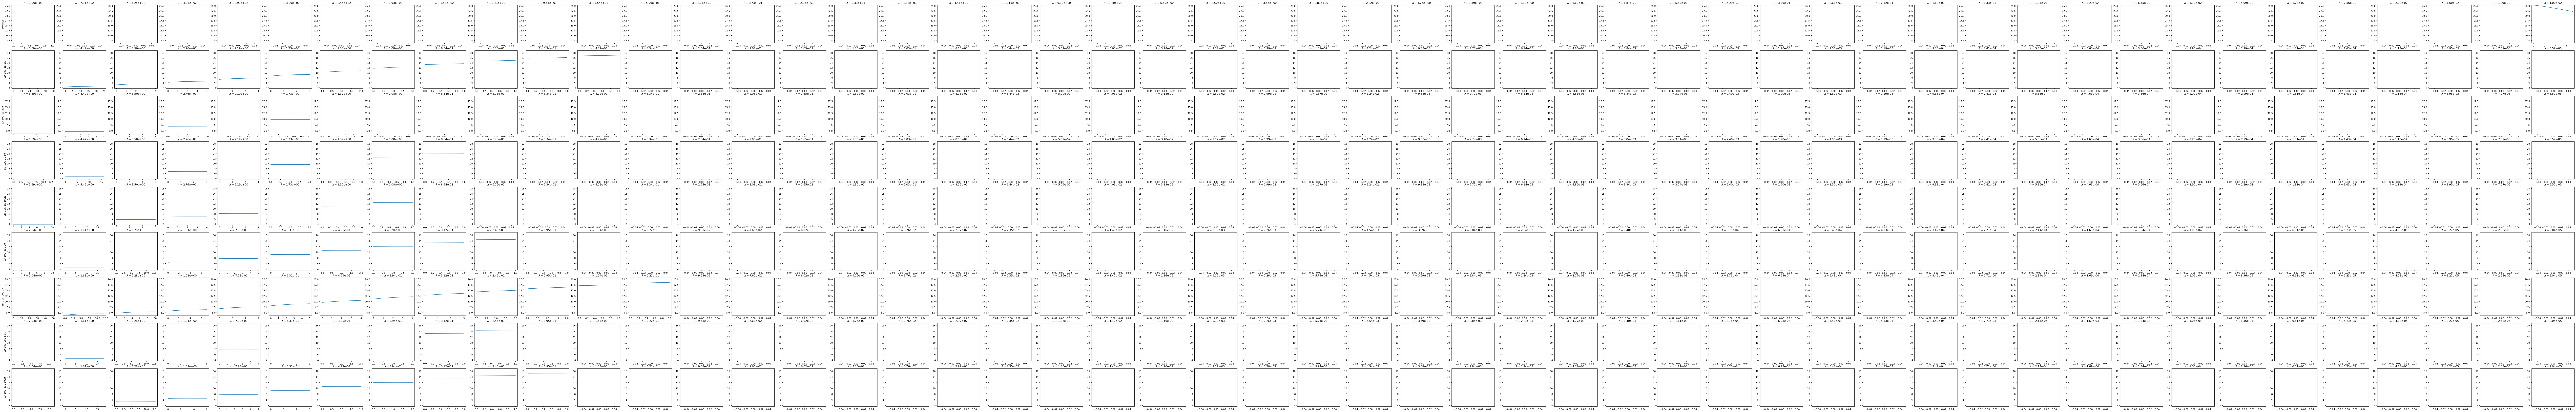

In [ ]:
fig, axs = plt.subplots(len(sublist_denoisers), n_lambda, figsize=(4*n_lambda, 3.5*len(sublist_denoisers)))

for i in range(len(sublist_denoisers)):
    axs[i, 0].set_ylabel(sublist_denoisers[i])
    res = list_results[0][sublist_denoisers[i]]
    
    y_values = []  # Collect y-values for this row

    for j in range(n_lambda):
        y = res["psnr_bis"][res["stops"][j]:res["stops"][j+1]]
        axs[i, j].plot(y)
        axs[i, j].set_title(rf"$\lambda=${res['lambda_list'][j]:.2e}")
        y_values.extend(y)  # Gather for consistent y-axis
    
    # Set same y-limits for the entire row
    y_min, y_max = min(y_values), max(y_values)
    for j in range(n_lambda):
        axs[i, j].set_ylim(y_min, y_max)

fig.savefig("warm_restart_deblurring_stop.pdf", bbox_inches="tight")

In [ ]:
n_plots = len(base_names)
n_img = len(indices)
n_rep_list = [20, 50, 100]

fig_lambda, axs_lambda = plt.subplots(
    n_plots+1, n_img, sharey=True, figsize=(4*n_img, 3*(n_plots+1))
)

for i, results in enumerate(list_results):
    
    x_observed = results["observation"].transpose(1, 2, 0).clip(0, 1)
    img = results["truth"].transpose(1, 2, 0).clip(0, 1)
    psnr = peak_signal_noise_ratio(img, x_observed.astype(np.float32))
    
    for k, base_name in enumerate(base_names):

        for rep in [1] + n_rep_list:
            
            name = f"{base_name}_{rep}R"
            res = results[name]
            axs_lambda[k, i].semilogx(res["lambda_list"], res['psnr'], label=rep)
        
        axs_lambda[k, i].set_title(f"{base_name}")
        axs_lambda[k, i].grid(True)
        axs_lambda[k, i].axhline(y=psnr, linestyle='--', alpha=0.5, color="grey")
        axs_lambda[k, i].legend(title="# iterations", fontsize=8, title_fontsize=8)
        axs_lambda[k, i].set_xlabel(rf"$\lambda$")
    
    name = "DRUNet"
    res = results[name]
    axs_lambda[-1, i].semilogx(res["lambda_list"], res['psnr'])
    axs_lambda[-1, i].set_title(f"{name}")
    axs_lambda[-1, i].grid(True)
    axs_lambda[-1, i].axhline(y=psnr, linestyle='--', alpha=0.5, color="grey")
    axs_lambda[-1, i].set_xlabel(rf"$\lambda$")

for ax in axs_lambda[:, 0]:
    ax.set_ylabel("PSNR (dB)")
fig_lambda.tight_layout(rect=[0, 0, 1, 0.9])
name_std = f"{STD_NOISE}".replace(".", "")
fig_lambda.savefig(f"warm_restart_deblurring_{name_std}_analysis.pdf", bbox_inches="tight")

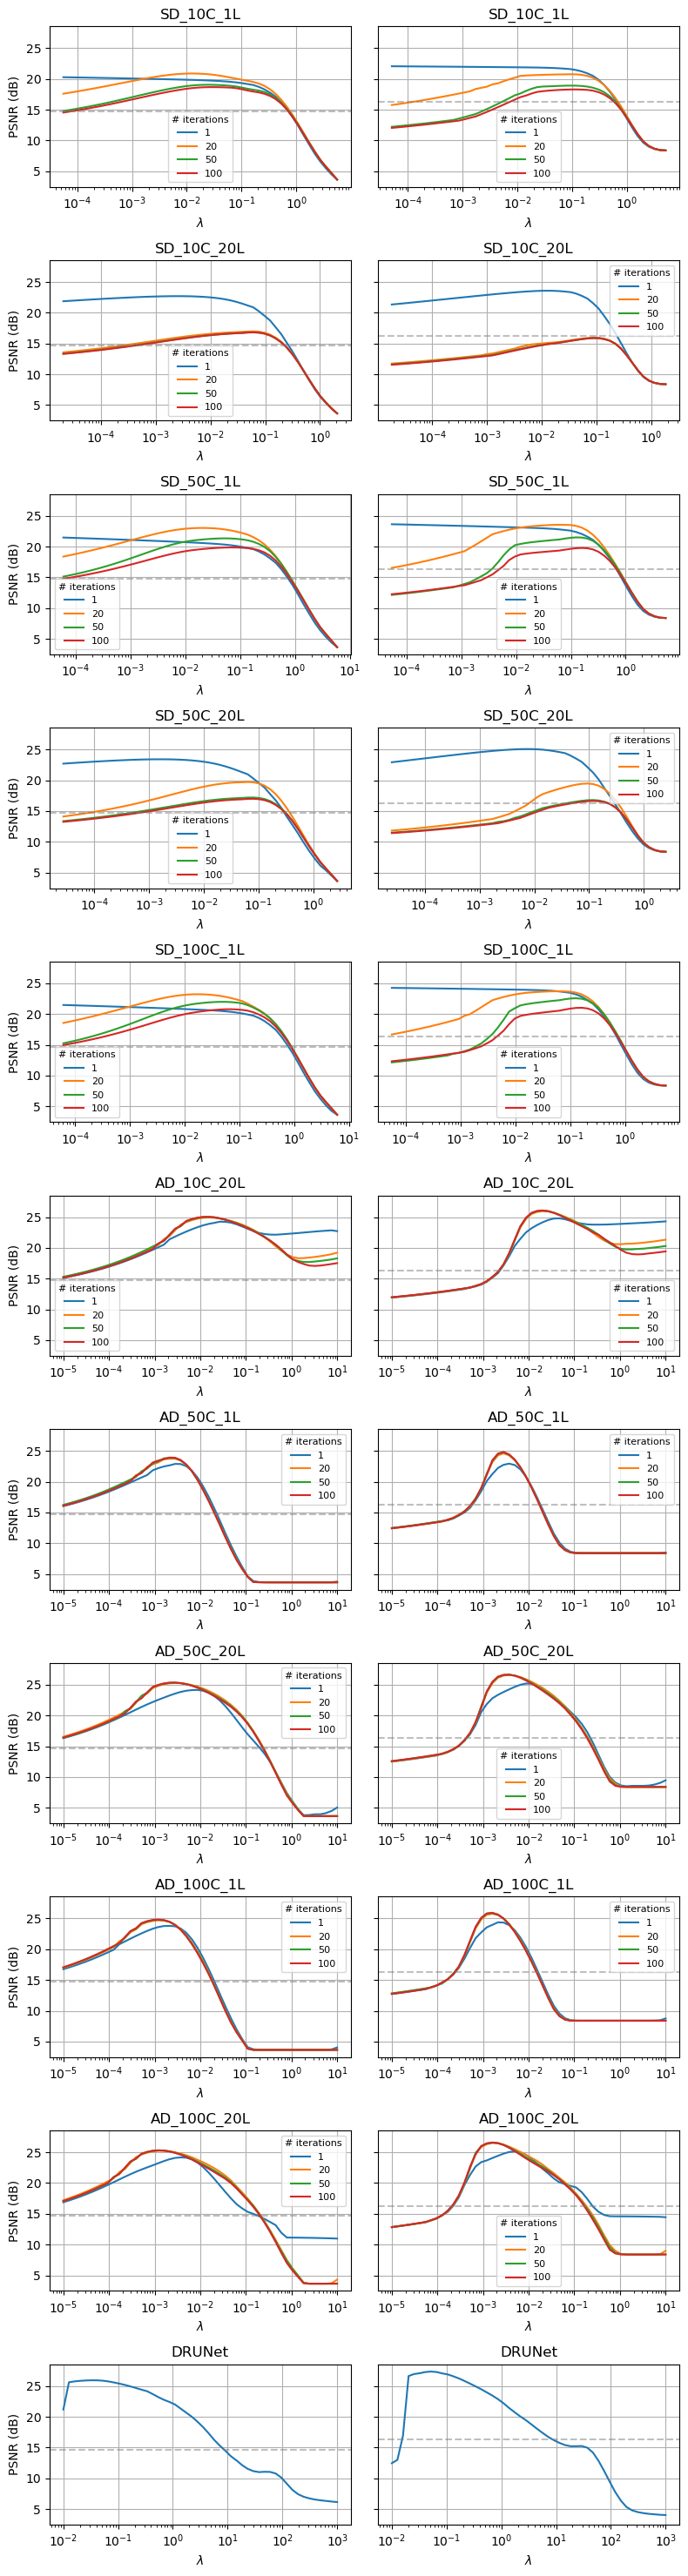

In [16]:
base_names = [
    "SD_10C_1L",
    "SD_10C_20L",
    "SD_50C_1L",
    "SD_50C_20L",
    "SD_100C_1L",
    # "SD_100C_20L",
    # "AD_10C_1L",
    "AD_10C_20L",
    "AD_50C_1L",
    "AD_50C_20L",
    "AD_100C_1L",
    "AD_100C_20L",
]

n_plots = len(base_names)
n_img = len(indices)
n_rep_list = [20, 50, 100]

fig_lambda, axs_lambda = plt.subplots(
    n_plots+1, n_img, sharey=True, figsize=(4*n_img, 3*(n_plots+1))
)

for i, results in enumerate(list_results):
    
    x_observed = results["observation"].transpose(1, 2, 0).clip(0, 1)
    img = results["truth"].transpose(1, 2, 0).clip(0, 1)
    psnr = peak_signal_noise_ratio(img, x_observed.astype(np.float32))
    
    for k, base_name in enumerate(base_names):

        for rep in [1] + n_rep_list:
            
            name = f"{base_name}_{rep}R"
            res = results[name]
            axs_lambda[k, i].semilogx(res["lambda_list"], res['psnr'], label=rep)
        
        axs_lambda[k, i].set_title(f"{base_name}")
        axs_lambda[k, i].grid(True)
        axs_lambda[k, i].axhline(y=psnr, linestyle='--', alpha=0.5, color="grey")
        axs_lambda[k, i].legend(title="# iterations", fontsize=8, title_fontsize=8)
        axs_lambda[k, i].set_xlabel(rf"$\lambda$")
    
    name = "DRUNet"
    res = results[name]
    axs_lambda[-1, i].semilogx(res["lambda_list"], res['psnr'])
    axs_lambda[-1, i].set_title(f"{name}")
    axs_lambda[-1, i].grid(True)
    axs_lambda[-1, i].axhline(y=psnr, linestyle='--', alpha=0.5, color="grey")
    axs_lambda[-1, i].set_xlabel(rf"$\lambda$")

for ax in axs_lambda[:, 0]:
    ax.set_ylabel("PSNR (dB)")
fig_lambda.tight_layout(rect=[0, 0, 1, 0.9])
name_std = f"{STD_NOISE}".replace(".", "")
fig_lambda.savefig(f"ZZZwarm_restart_deblurring_{name_std}.pdf", bbox_inches="tight")

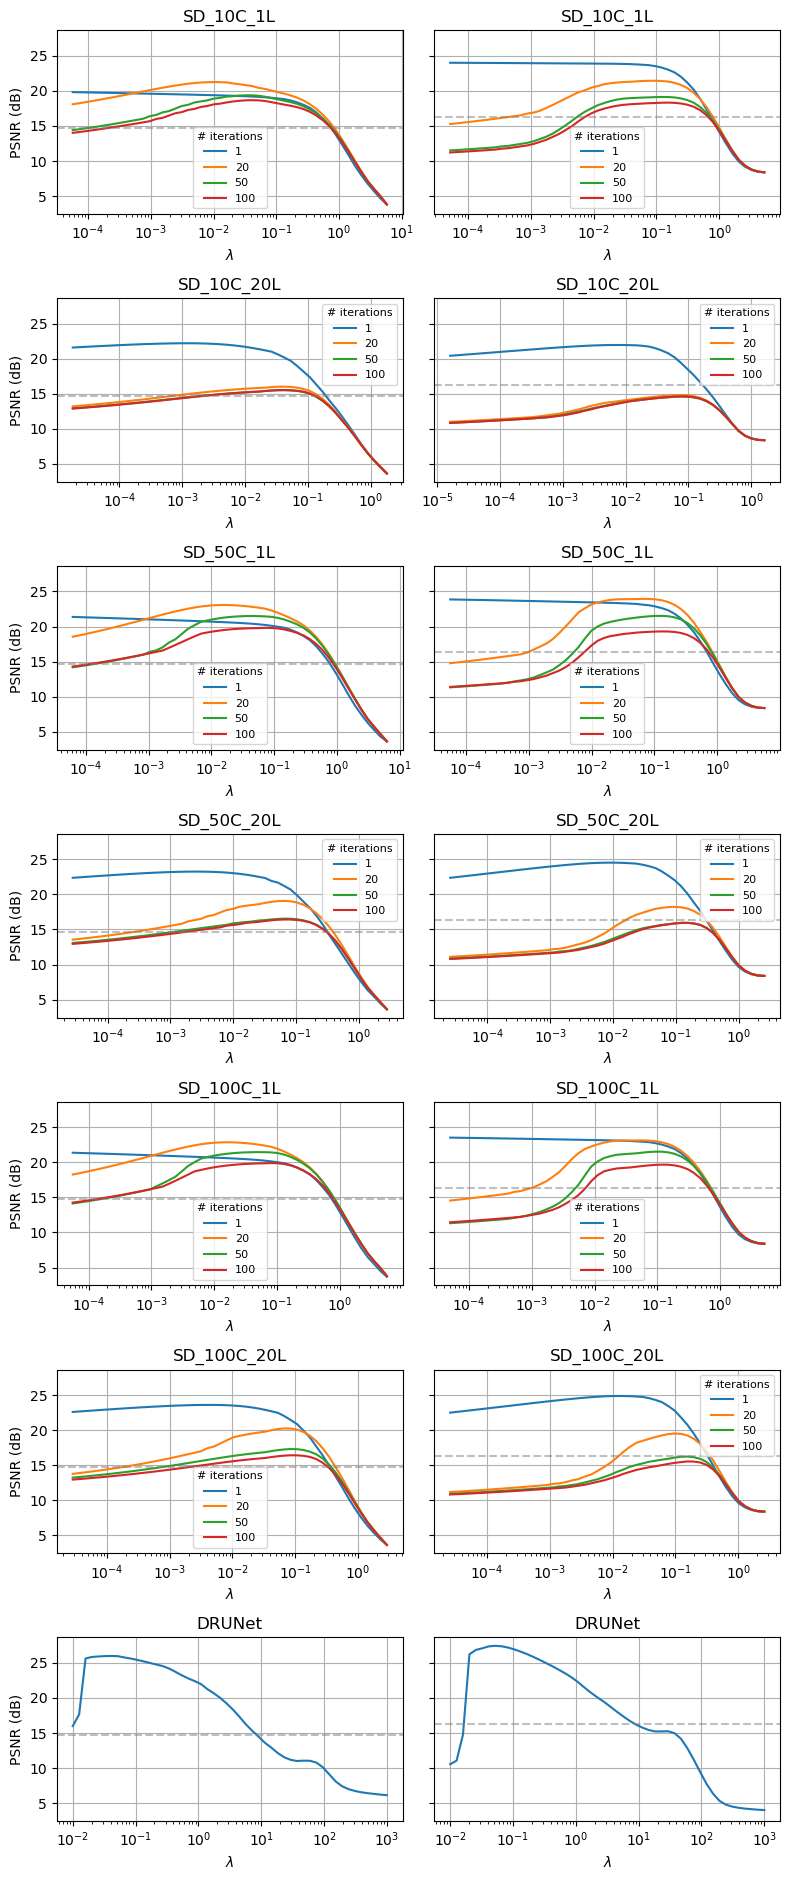

In [124]:
n_plots = len(base_names)
n_img = len(indices)

fig_lambda, axs_lambda = plt.subplots(
    n_plots+1, n_img, sharey=True, figsize=(4*n_img, 3*(n_plots+1))
)

for i, results in enumerate(list_results):
    
    x_observed = results["observation"].transpose(1, 2, 0).clip(0, 1)
    img = results["truth"].transpose(1, 2, 0).clip(0, 1)
    psnr = peak_signal_noise_ratio(img, x_observed.astype(np.float32))
    
    for k, base_name in enumerate(base_names):

        for rep in [1] + n_rep_list:
            
            name = f"{base_name}_{rep}R"
            res = results[name]
            axs_lambda[k, i].semilogx(res["lambda_list"], res['psnr'], label=rep)
        
        axs_lambda[k, i].set_title(f"{base_name}")
        axs_lambda[k, i].grid(True)
        axs_lambda[k, i].axhline(y=psnr, linestyle='--', alpha=0.5, color="grey")
        axs_lambda[k, i].legend(title="# iterations", fontsize=8, title_fontsize=8)
        axs_lambda[k, i].set_xlabel(rf"$\lambda$")
    
    name = "DRUNet"
    res = results[name]
    axs_lambda[-1, i].semilogx(res["lambda_list"], res['psnr'])
    axs_lambda[-1, i].set_title(f"{name}")
    axs_lambda[-1, i].grid(True)
    axs_lambda[-1, i].axhline(y=psnr, linestyle='--', alpha=0.5, color="grey")
    axs_lambda[-1, i].set_xlabel(rf"$\lambda$")

for ax in axs_lambda[:, 0]:
    ax.set_ylabel("PSNR (dB)")
fig_lambda.tight_layout(rect=[0, 0, 1, 0.9])
name_std = f"{STD_NOISE}".replace(".", "")
fig_lambda.savefig(f"warm_restart_deblurring_{name_std}.pdf", bbox_inches="tight")